In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/Resultats/Timewarp

alanine-dipeptide-fixed.pdb	    logs
alanine-dipeptide-nowater.pdb	    metadata.npy
alanine-dipeptide-solvated.pdb	    model_timewarp.ipynb
alanine-nowater.inpcrd		    Normalising_Flow_data.ipynb
alanine-nowater.prmtop		    ramachandran_comparison_1.png
best_timewarp_model.pth		    ramachandran_comparison.png
condacolab_install.log		    sampling_analysis.png
corrected_training_diagnostics.png  timewarp_exploration
data				    training_diagnostics.png
data_1				    training_pairs_augmented.npy


In [ ]:
%cd /content/drive/MyDrive/Resultats/Timewarp

/content/drive/MyDrive/Resultats/Timewarp


Forme: (1500, 2, 1, 22, 3)
Forme Après Squeeze: (1500, 2, 22, 3)
Ok
Formule correcte avec 1500training_pairs, 22atomes, 3dims
Standard: x^v(t) ~ N(0, I) - Independent Gaussian noise
Generated auxiliary velocity shapes: (1500, 2, 22, 3)
Speed statistics: mean=0.0008, std=0.9997

 Après renforcement: (1500, 2, 22, 6)
Single point in time shape: (22, 6)
Partie des positions: [[ 0.5086721  26.227764    4.5335627 ]
 [ 0.94007343 25.70236     3.7495258 ]
 [ 0.25203133 24.935602    3.5954065 ]]
Partie des vitesses: [[ 0.49671414 -0.1382643   0.64768857]
 [ 1.5230298  -0.23415338 -0.23413695]
 [ 1.5792128   0.7674347  -0.46947438]]

 data statistics:
Positions range: [-320.83, 185.09]
Velocities range: [-4.47, 4.56]
Velocities mean: 0.0008 (environ 0)
Velocities ecart-type: 0.9997 (environ 1)


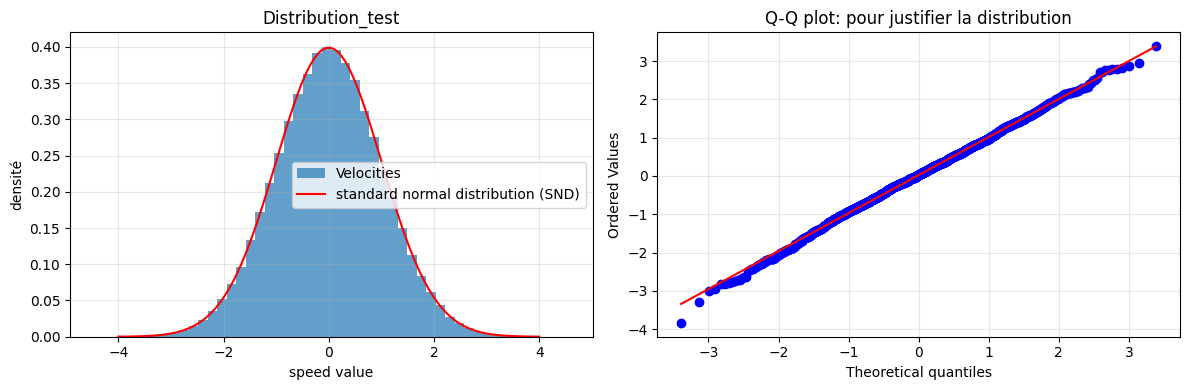


💾 Données améliorées sauvegardées: training_pairs_augmented_final.npy

🔄 验证保存的数据...
重新加载形状: (1500, 2, 22, 6)
数据类型: float32


In [ ]:
#Test si on peut utiliser Training_pairs.npy
import numpy as np
import matplotlib.pyplot as plt

pairs_array = np.load("data_1/training_pairs_addition.npy", allow_pickle=True)
print(f"Forme: {pairs_array.shape}")

#Squeeze
pairs_array = np.squeeze(pairs_array)
print(f"Forme Après Squeeze: {pairs_array.shape}")

assert pairs_array.shape == (1500, 2, 22, 3)
print("Ok")

if pairs_array.shape[1:] != (2, 22, 3):
   print("Formule incorrecte!")
   exit()

N_pairs, _, n_atoms, n_dims = pairs_array.shape
print(f"Formule correcte avec {N_pairs}training_pairs, {n_atoms}atomes, {n_dims}dims")

#Add the velocities
print("Standard: x^v(t) ~ N(0, I) - Independent Gaussian noise")
#Origine: (N_pairs, 2, n_atoms, 3) - seulement des positions
#But: (N_pairs, 2, n_atoms, 6) - positions+vitesse

np.random.seed(42)
auxiliary_velocities = np.random.normal(0, 1, size=(N_pairs, 2, n_atoms, 3)).astype(np.float32)

print(f"Generated auxiliary velocity shapes: {auxiliary_velocities.shape}")
print(f"Speed statistics: mean={auxiliary_velocities.mean():.4f}, std={auxiliary_velocities.std():.4f}")

#Combiner des positions et vitesses
augmented_pairs = np.concatenate([pairs_array, auxiliary_velocities], axis=-1)

print(f"\n Après renforcement: {augmented_pairs.shape}")


#Test again
sample_pair = augmented_pairs[0]
x_t = sample_pair[0]
x_t_tau = sample_pair[1]

print(f"Single point in time shape: {x_t.shape}")
print(f"Partie des positions: {x_t[:3, :3]}")
print(f"Partie des vitesses: {x_t[:3, 3:]}")

positions = augmented_pairs[:, :, :, :3]  # 位置
velocities = augmented_pairs[:, :, :, 3:]  # 速度

print(f"\n data statistics:")
print(f"Positions range: [{positions.min():.2f}, {positions.max():.2f}]")
print(f"Velocities range: [{velocities.min():.2f}, {velocities.max():.2f}]")
print(f"Velocities mean: {velocities.mean():.4f} (environ 0)")
print(f"Velocities ecart-type: {velocities.std():.4f} (environ 1)")

#Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

velocities_flat = velocities.flatten()
ax1.hist(velocities_flat, bins=50, alpha=0.7, density=True, label='Velocities')
x_range = np.linspace(-4, 4, 100)
ax1.plot(x_range, np.exp(-x_range**2/2)/np.sqrt(2*np.pi), 'r-', label='standard normal distribution (SND)')
ax1.set_xlabel('speed value')
ax1.set_ylabel('densité')
ax1.set_title('Distribution_test')
ax1.legend()
ax1.grid(True, alpha=0.3)

#Q-Q
from scipy import stats
stats.probplot(velocities_flat[::100], dist="norm", plot=ax2)
ax2.set_title('Q-Q plot: pour justifier la distribution')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7. 保存增强数据
output_filename = "training_pairs_augmented_final.npy"
np.save(output_filename, augmented_pairs)
print(f"\n💾 Données améliorées sauvegardées: {output_filename}")

# 8. 验证保存的数据
print("\n🔄 验证保存的数据...")
loaded_augmented = np.load(output_filename)
print(f"重新加载形状: {loaded_augmented.shape}")
print(f"数据类型: {loaded_augmented.dtype}")

数据第二组apres un regulation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from typing import Optional, Tuple
import math

class AtomEmbedder(nn.Module):
    """原子嵌入层"""
    def __init__(self, num_atom_types: int, embedding_dim: int):
        super().__init__()
        self.embedding = nn.Embedding(num_atom_types, embedding_dim)

    def forward(self, atom_types: Tensor) -> Tensor:
        """
        Args:
            atom_types: [batch_size, num_atoms] - 原子类型索引
        Returns:
            [batch_size, num_atoms, embedding_dim] - 原子嵌入
        """
        return self.embedding(atom_types)

class KernelSelfAttention(nn.Module):
    """
    Kernel Self-Attention (基于 RBF 核的自注意力)
    论文方程 (10) 和 (11)
    """
    def __init__(self, input_dim: int, output_dim: int, lengthscales: list):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lengthscales = lengthscales
        self.num_heads = len(lengthscales)

        # 确保 output_dim 能被 num_heads 整除
        self.head_dim = output_dim // self.num_heads
        if output_dim % self.num_heads != 0:
            # 调整 head_dim 确保维度匹配
            self.head_dim = output_dim // self.num_heads + 1
            print(f"Warning: Adjusting head_dim from {output_dim // self.num_heads} to {self.head_dim} to ensure divisibility")

        self.total_head_dim = self.head_dim * self.num_heads

        # 每个头的变换矩阵 V
        self.value_projections = nn.ModuleList([
            nn.Linear(input_dim, self.head_dim)
            for _ in range(self.num_heads)
        ])

        # 最终的输出投影 - 从拼接的头维度到期望的输出维度
        self.output_projection = nn.Linear(self.total_head_dim, output_dim)

    def forward(self, features: Tensor, coords: Tensor) -> Tensor:
        """
        Args:
            features: [batch_size, num_atoms, input_dim] - 输入特征
            coords: [batch_size, num_atoms, 3] - 原子坐标
        Returns:
            [batch_size, num_atoms, output_dim] - 输出特征
        """
        batch_size, num_atoms, _ = features.shape

        # 计算原子间距离矩阵 - 论文方程 (10)
        coords_i = coords.unsqueeze(2)  # [B, N, 1, 3]
        coords_j = coords.unsqueeze(1)  # [B, 1, N, 3]
        distances_sq = torch.sum((coords_i - coords_j) ** 2, dim=-1)  # [B, N, N]

        # 多头注意力
        head_outputs = []
        for head_idx, lengthscale in enumerate(self.lengthscales):
            # 计算 RBF 核注意力权重 (方程 10)
            attention_weights = torch.exp(-distances_sq / (lengthscale ** 2))  # [B, N, N]

            # 归一化权重
            attention_weights = attention_weights / (attention_weights.sum(dim=-1, keepdim=True) + 1e-8)

            # 应用注意力 (方程 11)
            value = self.value_projections[head_idx](features)  # [B, N, head_dim]
            attended_features = torch.bmm(attention_weights, value)  # [B, N, head_dim]
            head_outputs.append(attended_features)

        # 拼接多头输出
        multi_head_output = torch.cat(head_outputs, dim=-1)  # [B, N, total_head_dim]

        # 最终投影到期望的输出维度
        return self.output_projection(multi_head_output)

class AtomTransformer(nn.Module):
    """
    Atom Transformer - 论文中的核心组件，用作 s_θ 和 t_θ 函数
    论文 Section 4 和 Figure 2 Middle
    """
    def __init__(self, embedding_dim: int, hidden_dim: int, lengthscales: list, num_layers: int = 2):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # φ_in: 输入 MLP
        # 输入是 [x_p_i(t), h_i, z_v_i] 或 [x_p_i(t), h_i, z_p_i] - 论文 Section 4
        self.input_mlp = nn.Sequential(
            nn.Linear(3 + embedding_dim + 3, hidden_dim),  # coords + embedding + latent
            nn.ReLU()
        )

        # Transformer 层
        self.transformer_layers = nn.ModuleList([
            TransformerBlock(hidden_dim, lengthscales)
            for _ in range(num_layers)
        ])

        # φ_out: 输出 MLP
        self.output_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3)  # 输出 3D 向量
        )

    def forward(self, latent_vars: Tensor, x_coords: Tensor, atom_embeddings: Tensor) -> Tensor:
        """
        Args:
            latent_vars: [B, N, 3] - z_v 或 z_p
            x_coords: [B, N, 3] - 条件坐标 x_p(t)
            atom_embeddings: [B, N, embedding_dim] - 原子嵌入 h_i
        Returns:
            [B, N, 3] - scale 或 shift 向量
        """
        # 拼接输入：[x_p_i(t), h_i, z_v_i] - 论文 Section 4
        input_features = torch.cat([x_coords, atom_embeddings, latent_vars], dim=-1)

        # φ_in
        features = self.input_mlp(input_features)

        # Transformer 层 - 使用 x_coords 进行 kernel attention
        for layer in self.transformer_layers:
            features = layer(features, x_coords)

        # φ_out
        output = self.output_mlp(features)

        return output

class TransformerBlock(nn.Module):
    """Transformer 块 (包含 Kernel Self-Attention)"""
    def __init__(self, hidden_dim: int, lengthscales: list):
        super().__init__()
        self.kernel_attention = KernelSelfAttention(hidden_dim, hidden_dim, lengthscales)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)

        # Feed-forward 网络 - 论文称为 "atom-wise MLP"
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )

    def forward(self, features: Tensor, coords: Tensor) -> Tensor:
        """
        Args:
            features: [batch_size, num_atoms, hidden_dim]
            coords: [batch_size, num_atoms, 3]
        Returns:
            [batch_size, num_atoms, hidden_dim]
        """
        # Self-attention + residual connection + norm
        attended = self.kernel_attention(features, coords)
        features = self.norm1(features + attended)

        # Feed-forward + residual connection + norm
        ffn_output = self.ffn(features)
        features = self.norm2(features + ffn_output)

        return features

class TimewarpCouplingLayer(nn.Module):
    """
    Timewarp RealNVP 耦合层 - 论文方程 (8) 和 (9)
    这是论文的核心创新：使用 Atom Transformer 作为 s_θ 和 t_θ 函数
    """
    def __init__(self, embedding_dim: int, hidden_dim: int, lengthscales: list):
        super().__init__()

        # 用于位置变换的 Atom Transformers - 论文方程 (8)
        self.scale_transformer_p = AtomTransformer(embedding_dim, hidden_dim, lengthscales)
        self.shift_transformer_p = AtomTransformer(embedding_dim, hidden_dim, lengthscales)

        # 用于速度变换的 Atom Transformers - 论文方程 (9)
        self.scale_transformer_v = AtomTransformer(embedding_dim, hidden_dim, lengthscales)
        self.shift_transformer_v = AtomTransformer(embedding_dim, hidden_dim, lengthscales)

    def forward(self, z_p: Tensor, z_v: Tensor, x_coords: Tensor,
                atom_embeddings: Tensor, reverse: bool = False) -> Tuple[Tensor, Tensor, Tensor]:
        """
        Args:
            z_p: [B, N, 3] - 位置潜在变量
            z_v: [B, N, 3] - 速度潜在变量
            x_coords: [B, N, 3] - 条件坐标 x_p(t)
            atom_embeddings: [B, N, embedding_dim] - 原子嵌入
            reverse: 是否反向传播
        Returns:
            z_p_new, z_v_new, log_det_jacobian
        """
        if not reverse:
            # 前向传播 - 论文方程 (8) 和 (9)

            # 步骤1：变换位置 - z^p_{ℓ+1} = s^p_{ℓ,θ}(z^v_ℓ; x^p(t)) ⊙ z^p_ℓ + t^p_{ℓ,θ}(z^v_ℓ; x^p(t))
            scale_p = self.scale_transformer_p(z_v, x_coords, atom_embeddings)  # s^p_{ℓ,θ}(z^v_ℓ; x^p(t))
            shift_p = self.shift_transformer_p(z_v, x_coords, atom_embeddings)  # t^p_{ℓ,θ}(z^v_ℓ; x^p(t))

            z_p_new = torch.exp(scale_p) * z_p + shift_p
            log_det_p = scale_p.sum(dim=-1)  # [B, N]

            # 步骤2：变换速度 - z^v_{ℓ+1} = s^v_{ℓ,θ}(z^p_{ℓ+1}; x^p(t)) ⊙ z^v_ℓ + t^v_{ℓ,θ}(z^p_{ℓ+1}; x^p(t))
            scale_v = self.scale_transformer_v(z_p_new, x_coords, atom_embeddings)  # s^v_{ℓ,θ}(z^p_{ℓ+1}; x^p(t))
            shift_v = self.shift_transformer_v(z_p_new, x_coords, atom_embeddings)  # t^v_{ℓ,θ}(z^p_{ℓ+1}; x^p(t))

            z_v_new = torch.exp(scale_v) * z_v + shift_v
            log_det_v = scale_v.sum(dim=-1)  # [B, N]

            total_log_det = log_det_p + log_det_v  # [B, N]

        else:
            # 反向传播 (采样)

            # 步骤1：反向变换速度
            scale_v = self.scale_transformer_v(z_p, x_coords, atom_embeddings)
            shift_v = self.shift_transformer_v(z_p, x_coords, atom_embeddings)

            z_v_new = (z_v - shift_v) * torch.exp(-scale_v)
            log_det_v = -scale_v.sum(dim=-1)

            # 步骤2：反向变换位置
            scale_p = self.scale_transformer_p(z_v_new, x_coords, atom_embeddings)
            shift_p = self.shift_transformer_p(z_v_new, x_coords, atom_embeddings)

            z_p_new = (z_p - shift_p) * torch.exp(-scale_p)
            log_det_p = -scale_p.sum(dim=-1)

            total_log_det = log_det_p + log_det_v

        return z_p_new, z_v_new, total_log_det

class TimewarpModel(nn.Module):
    """
    完整的 Timewarp 模型 - 严格按照论文实现
    核心思想：使用 conditional normalizing flow 学习 μ(x(t+τ)|x(t))
    """
    def __init__(
        self,
        num_atom_types: int,
        embedding_dim: int = 64,
        hidden_dim: int = 128,
        num_coupling_layers: int = 12,
        lengthscales: list = [0.1, 0.2, 0.5, 0.7, 1.0, 1.2]
    ):
        super().__init__()

        # 1. 原子嵌入器
        self.atom_embedder = AtomEmbedder(num_atom_types, embedding_dim)

        # 2. RealNVP 耦合层堆叠 - 论文 Figure 2 Left
        self.coupling_layers = nn.ModuleList([
            TimewarpCouplingLayer(embedding_dim, hidden_dim, lengthscales)
            for _ in range(num_coupling_layers)
        ])

        # 3. 基础分布的尺度参数 (可学习)
        self.register_parameter('log_scale', nn.Parameter(torch.zeros(1)))

    def forward(
        self,
        atom_types: Tensor,      # [batch_size, num_atoms] - 原子类型
        x_coords: Tensor,        # [batch_size, num_atoms, 3] - 条件坐标 x^p(t)
        y_coords: Tensor = None, # [batch_size, num_atoms, 3] - 目标坐标 x^p(t+τ) (训练时)
        reverse: bool = False    # 是否为采样模式
    ) -> Tuple[Tensor, Optional[Tensor]]:
        """
        Args:
            atom_types: 原子类型索引
            x_coords: 条件坐标 x^p(t)
            y_coords: 目标坐标 x^p(t+τ) (训练时使用)
            reverse: False=训练模式, True=采样模式
        Returns:
            output_coords: 输出坐标
            log_likelihood: 对数似然 (仅训练时)
        """
        batch_size, num_atoms = atom_types.shape

        # 1. 原子嵌入 - 论文 Section 4
        atom_embeddings = self.atom_embedder(atom_types)  # [B, N, embedding_dim]

        # 2. 中心化坐标 (translation equivariance) - 论文 Appendix A.2
        x_coords_centered = self._center_coordinates(x_coords)

        if not reverse:
            # 训练模式：计算 p_θ(x(t+τ)|x(t))
            if y_coords is None:
                raise ValueError("训练模式需要提供目标坐标 y_coords")

            # 中心化目标坐标
            y_coords_centered = self._center_coordinates(y_coords)

            # 采样辅助变量 - 论文 Section 3.3 Augmented Normalizing Flows
            z_v = torch.randn_like(y_coords_centered)  # auxiliary variables ~ N(0, I)
            z_p = y_coords_centered  # 位置作为主要变量

            # 通过耦合层 (前向)
            total_log_det = torch.zeros(batch_size, num_atoms, device=x_coords.device)

            for layer in self.coupling_layers:
                z_p, z_v, log_det = layer(z_p, z_v, x_coords_centered, atom_embeddings, reverse=False)
                total_log_det += log_det

            # 计算基础分布的对数概率 - N(0, σ²I)
            scale = torch.exp(self.log_scale)
            log_prior_p = -0.5 * torch.sum((z_p / scale) ** 2, dim=-1)  # [B, N]
            log_prior_v = -0.5 * torch.sum((z_v / scale) ** 2, dim=-1)  # [B, N]
            log_prior = log_prior_p + log_prior_v

            # 总对数似然
            log_likelihood = log_prior + total_log_det  # [B, N]

            return y_coords, log_likelihood

        else:
            # 采样模式：生成 x(t+τ) ~ p_θ(·|x(t))

            # 从基础分布采样
            scale = torch.exp(self.log_scale)
            z_p = torch.randn(batch_size, num_atoms, 3, device=x_coords.device) * scale
            z_v = torch.randn(batch_size, num_atoms, 3, device=x_coords.device) * scale

            # 通过耦合层 (反向)
            for layer in reversed(self.coupling_layers):
                z_p, z_v, _ = layer(z_p, z_v, x_coords_centered, atom_embeddings, reverse=True)

            # z_p 现在是中心化的输出坐标
            output_coords = self._uncenter_coordinates(z_p, x_coords)

            return output_coords, None

    def _center_coordinates(self, coords: Tensor) -> Tensor:
        """中心化坐标 - 论文 Appendix A.2"""
        centroid = coords.mean(dim=1, keepdim=True)  # [B, 1, 3]
        return coords - centroid

    def _uncenter_coordinates(self, centered_coords: Tensor, reference_coords: Tensor) -> Tensor:
        """恢复坐标中心"""
        reference_centroid = reference_coords.mean(dim=1, keepdim=True)
        return centered_coords + reference_centroid

    def sample(self, atom_types: Tensor, x_coords: Tensor, num_samples: int = 1) -> Tensor:
        """便捷的采样接口"""
        self.eval()
        with torch.no_grad():
            if num_samples == 1:
                output_coords, _ = self.forward(atom_types, x_coords, reverse=True)
                return output_coords
            else:
                # 批量采样
                samples = []
                for _ in range(num_samples):
                    output_coords, _ = self.forward(atom_types, x_coords, reverse=True)
                    samples.append(output_coords)
                return torch.stack(samples, dim=0)

def create_timewarp_model(config: dict) -> TimewarpModel:
    """创建 Timewarp 模型的工厂函数"""
    return TimewarpModel(
        num_atom_types=config.get('num_atom_types', 10),
        embedding_dim=config.get('embedding_dim', 64),
        hidden_dim=config.get('hidden_dim', 128),
        num_coupling_layers=config.get('num_coupling_layers', 12),
        lengthscales=config.get('lengthscales', [0.1, 0.2, 0.5, 0.7, 1.0, 1.2])
    )

# 论文中的配置参数
paper_config = {
    'num_atom_types': 20,        # 20种氨基酸
    'embedding_dim': 64,         # 论文 Table 3
    'hidden_dim': 128,           # 论文 Table 3
    'num_coupling_layers': 12,   # 论文 Table 3 - AD dataset
    'lengthscales': [0.1, 0.2, 0.5, 0.7, 1.0, 1.2]  # 论文 Appendix F
}

开始训练修正版Timewarp模型...
=== 开始训练修正版Timewarp模型 ===
=== 数据分析 ===
数据形状: (1500, 2, 22, 6)
位置统计:
  均值: [-65.9339    48.867912 -29.01765 ]
  标准差: [79.31865 50.37196 88.95445]
  范围: [-320.83386  -71.58014 -221.85976] 到 [ 57.772415 185.08672  150.53256 ]
位置变化统计:
  均值: [-0.1502897   0.11939198 -0.07053946]
  标准差: [3.2871857 3.254189  3.3162246]
=== 数据标准化 ===
位置标准化: 均值=-15.3612, 标准差=88.7152
训练集大小: 1200
测试集大小: 300
模型参数量: 3,016,137
Epoch [1/150], Train Loss: -7.1278, Test Loss: -8.7903, Train LL: 7.1278, Test LL: 8.7903, Pos Error: 0.001626, LR: 1.00e-04
Epoch [2/150], Train Loss: -8.9126, Test Loss: -8.9970, Train LL: 8.9126, Test LL: 8.9970
Epoch [3/150], Train Loss: -8.9970, Test Loss: -9.0456, Train LL: 8.9970, Test LL: 9.0456
Epoch [4/150], Train Loss: -9.0987, Test Loss: -9.1080, Train LL: 9.0987, Test LL: 9.1080
Epoch [5/150], Train Loss: -9.1738, Test Loss: -9.2546, Train LL: 9.1738, Test LL: 9.2546
Epoch [6/150], Train Loss: -9.2835, Test Loss: -9.3190, Train LL: 9.2835, Test LL: 9.3190
Epoc

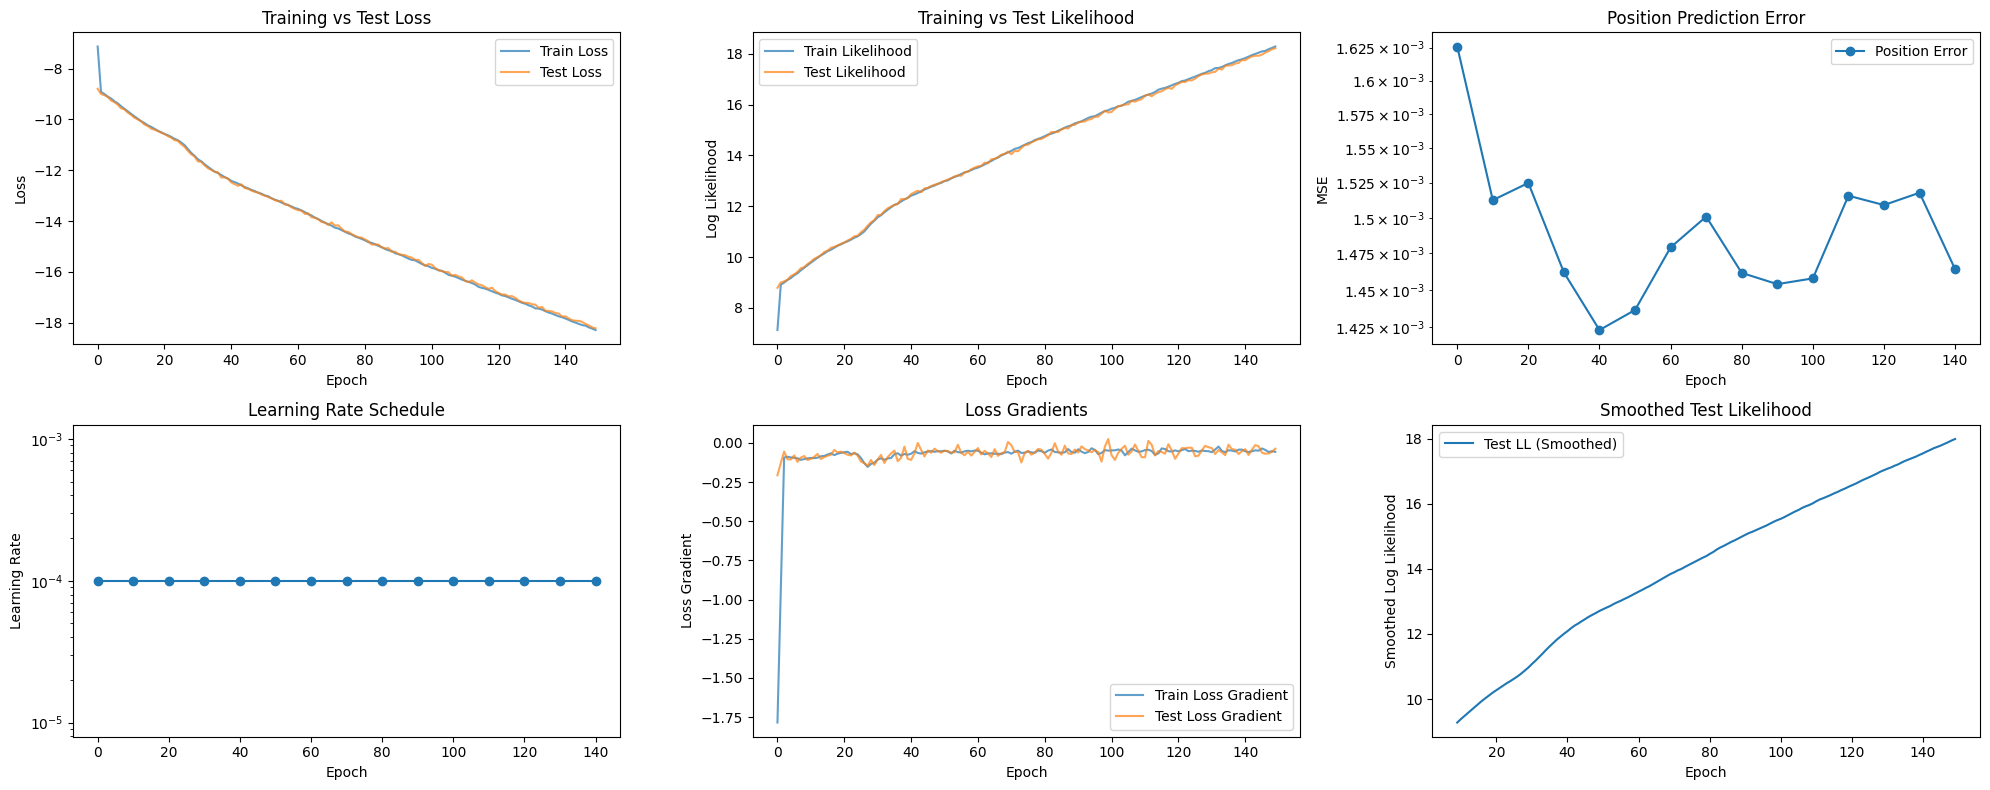


=== 采样分析 ===
采样方差: 0.000254


/tmp/ipython-input-16-4184712202.py:186: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-16-4184712202.py:186: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-16-4184712202.py:186: UserWarning: Glyph 36712 (\N{CJK UNIFIED IDEOGRAPH-8F68}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-16-4184712202.py:186: UserWarning: Glyph 36857 (\N{CJK UNIFIED IDEOGRAPH-8FF9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-16-4184712202.py:186: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-16-4184712202.py:186: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-16-4184712202.py:186: UserWarning: Glyph 39044 (\N{CJK UN

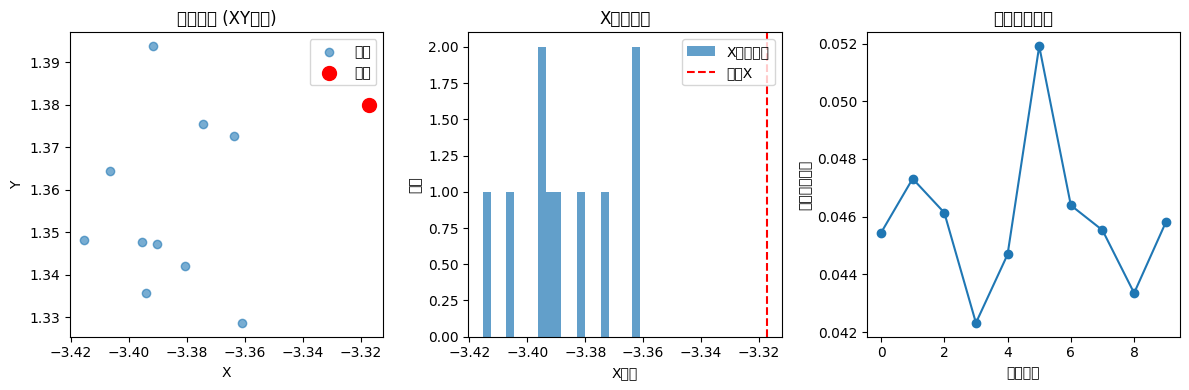


开始测试模型...
=== 测试修正模型预测质量 ===
坐标预测方差: 0.001513
坐标预测标准差: 0.034353
坐标预测范围: -0.1664 到 0.2094
原子间距离统计:
  最小距离: 0.0042
  平均距离: 0.0897
  最大距离: 0.2962
过近接触 (<0.1): 7248 / 11550 (62.75%)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import os

class MolecularDataset(Dataset):
    """分子动力学数据集 - 适配新模型架构"""
    def __init__(self, data_indices, full_data, num_atom_types=4):
        """
        Args:
            data_indices: 数据索引列表
            full_data: 完整数据数组
            num_atom_types: 原子类型数量
        """
        self.data_indices = data_indices
        self.full_data = full_data
        self.num_atom_types = num_atom_types
        _, _, self.num_atoms, _ = full_data.shape

    def __len__(self):
        return len(self.data_indices)

    def __getitem__(self, idx):
        data_idx = self.data_indices[idx]
        pair = self.full_data[data_idx]  # [2, num_atoms, 6]

        # 分离时间步
        t_data = pair[0]      # [num_atoms, 6] - t时刻数据
        t_tau_data = pair[1]  # [num_atoms, 6] - t+τ时刻数据

        # 分离位置 (新模型只需要位置，不需要速度作为输入)
        x_coords = t_data[:, :3]      # t时刻位置 - 条件输入
        y_coords = t_tau_data[:, :3]  # t+τ时刻位置 - 目标输出

        # 注意：不再手动中心化，模型内部会处理
        # x_coords = x_coords - np.mean(x_coords, axis=0, keepdims=True)
        # y_coords = y_coords - np.mean(y_coords, axis=0, keepdims=True)

        # alanine-dipeptide的原子类型序列
        atom_types = torch.tensor([0, 1, 0, 2, 3, 3, 3, 0, 3, 0, 2, 1, 3, 0, 0, 2, 3, 3, 3, 3, 3, 3], dtype=torch.long)

        return {
            'atom_types': atom_types,
            'x_coords': torch.FloatTensor(x_coords),      # 条件坐标
            'y_coords': torch.FloatTensor(y_coords),      # 目标坐标
            'data_idx': data_idx  # 添加数据索引用于调试
        }

def analyze_data_distribution(data_path):
    """分析数据分布"""
    print("=== 数据分析 ===")
    data = np.load(data_path)
    print(f"数据形状: {data.shape}")

    # 只分析位置的分布 (新模型只关心位置)
    positions = data[:, :, :, :3].reshape(-1, 3)

    print(f"位置统计:")
    print(f"  均值: {positions.mean(axis=0)}")
    print(f"  标准差: {positions.std(axis=0)}")
    print(f"  范围: {positions.min(axis=0)} 到 {positions.max(axis=0)}")

    # 分析位置变化的统计
    position_changes = []
    for i in range(data.shape[0]):
        pos_change = data[i, 1, :, :3] - data[i, 0, :, :3]  # t+τ - t
        position_changes.append(pos_change)

    position_changes = np.array(position_changes).reshape(-1, 3)
    print(f"位置变化统计:")
    print(f"  均值: {position_changes.mean(axis=0)}")
    print(f"  标准差: {position_changes.std(axis=0)}")

    return data

def normalize_data(data):
    """标准化数据 - 只标准化位置"""
    print("=== 数据标准化 ===")
    normalized_data = data.copy()

    # 只标准化位置
    positions = data[:, :, :, :3]

    # 计算全局统计量
    pos_mean = positions.mean()
    pos_std = positions.std()

    print(f"位置标准化: 均值={pos_mean:.4f}, 标准差={pos_std:.4f}")

    # 标准化位置
    normalized_data[:, :, :, :3] = (positions - pos_mean) / pos_std
    # 保持速度不变 (虽然新模型不用，但保持数据完整性)
    normalized_data[:, :, :, 3:] = data[:, :, :, 3:]

    return normalized_data, (pos_mean, pos_std)

def compute_physics_metrics(model, dataloader, device):
    """计算物理相关的指标 - 适配新模型"""
    model.eval()
    total_position_error = 0
    total_likelihood = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            atom_types = batch['atom_types'].to(device)
            x_coords = batch['x_coords'].to(device)
            y_coords = batch['y_coords'].to(device)

            # 计算似然 (训练模式)
            _, log_likelihood = model(
                atom_types, x_coords, y_coords, reverse=False
            )
            avg_likelihood = log_likelihood.mean()

            # 采样预测 (推理模式)
            pred_coords, _ = model(
                atom_types, x_coords, reverse=True
            )

            # 计算位置L2误差
            pos_error = torch.mean((pred_coords - y_coords) ** 2)

            total_position_error += pos_error.item()
            total_likelihood += avg_likelihood.item()
            total_samples += 1

    return total_position_error / total_samples, total_likelihood / total_samples

def sample_and_visualize(model, dataloader, device, num_samples=5):
    """采样并可视化结果"""
    model.eval()

    with torch.no_grad():
        # 获取一个批次的数据
        batch = next(iter(dataloader))
        atom_types = batch['atom_types'][:num_samples].to(device)
        x_coords = batch['x_coords'][:num_samples].to(device)
        y_coords = batch['y_coords'][:num_samples].to(device)

        # 多次采样来评估模型的随机性
        samples = []
        for _ in range(10):
            pred_coords, _ = model(atom_types, x_coords, reverse=True)
            samples.append(pred_coords.cpu().numpy())

        samples = np.array(samples)  # [10, num_samples, num_atoms, 3]

        # 计算采样方差
        sample_variance = np.var(samples, axis=0).mean()
        print(f"采样方差: {sample_variance:.6f}")

        # 可视化第一个分子的第一个原子的轨迹
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.scatter(samples[:, 0, 0, 0], samples[:, 0, 0, 1], alpha=0.6, label='预测')
        plt.scatter(y_coords[0, 0, 0].cpu(), y_coords[0, 0, 1].cpu(), color='red', s=100, label='真实')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('原子轨迹 (XY平面)')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.hist(samples[:, 0, 0, 0], bins=20, alpha=0.7, label='X坐标分布')
        plt.axvline(y_coords[0, 0, 0].cpu(), color='red', linestyle='--', label='真实X')
        plt.xlabel('X坐标')
        plt.ylabel('频次')
        plt.title('X坐标分布')
        plt.legend()

        plt.subplot(1, 3, 3)
        # 计算与真实值的距离
        distances = np.sqrt(np.sum((samples - y_coords.cpu().numpy()) ** 2, axis=-1))
        mean_distances = distances.mean(axis=(1, 2))
        plt.plot(mean_distances, 'o-')
        plt.xlabel('采样次数')
        plt.ylabel('平均距离误差')
        plt.title('预测误差分布')

        plt.tight_layout()
        plt.savefig('sampling_analysis.png', dpi=150, bbox_inches='tight')
        plt.show()

def train_timewarp_model_corrected(
    data_path='training_pairs_augmented_final.npy',
    num_epochs=200,
    batch_size=16,
    learning_rate=1e-4,
    test_size=0.2,
    normalize=True,
    device='cuda' if torch.cuda.is_available() else 'cpu'
):
    """修正后的训练函数"""

    print("=== 开始训练修正版Timewarp模型 ===")

    # 1. 分析和加载数据
    full_data = analyze_data_distribution(data_path)

    # 2. 数据标准化
    if normalize:
        full_data, norm_stats = normalize_data(full_data)

    # 3. 划分训练集和测试集
    num_samples = len(full_data)
    indices = np.arange(num_samples)
    train_indices, test_indices = train_test_split(
        indices, test_size=test_size, random_state=42, shuffle=True
    )

    print(f"训练集大小: {len(train_indices)}")
    print(f"测试集大小: {len(test_indices)}")

    # 4. 创建数据集
    train_dataset = MolecularDataset(train_indices, full_data)
    test_dataset = MolecularDataset(test_indices, full_data)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 5. 创建模型 - 使用能被头数整除的维度配置
    config = {
        'num_atom_types': 4,              # alanine dipeptide的原子类型
        'embedding_dim': 32,              # 32能被多种头数整除
        'hidden_dim': 96,                 # 96 = 32 * 3，能被3整除
        'num_coupling_layers': 6,         # 较少的耦合层
        'lengthscales': [0.1, 0.3, 0.8]   # 3个头，96/3=32维度完美匹配
    }

    model = create_timewarp_model(config).to(device)

    # 使用论文中的优化器设置
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=20)

    print(f"模型参数量: {sum([p.numel() for p in model.parameters()]):,}")

    # 6. 训练历史记录
    train_losses = []
    test_losses = []
    train_likelihoods = []
    test_likelihoods = []
    position_errors = []

    best_test_likelihood = float('-inf')

    # 7. 训练循环
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0
        train_likelihood = 0
        num_train_batches = 0

        for batch in train_loader:
            atom_types = batch['atom_types'].to(device)
            x_coords = batch['x_coords'].to(device)
            y_coords = batch['y_coords'].to(device)

            optimizer.zero_grad()

            # 计算负对数似然
            _, log_likelihood = model(
                atom_types, x_coords, y_coords, reverse=False
            )

            # 负对数似然作为损失
            loss = -log_likelihood.mean()

            # 检查数值稳定性
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"警告: 检测到NaN或Inf损失在epoch {epoch}")
                continue

            loss.backward()

            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            train_likelihood += log_likelihood.mean().item()
            num_train_batches += 1

        avg_train_loss = train_loss / num_train_batches
        avg_train_likelihood = train_likelihood / num_train_batches

        # 测试阶段
        model.eval()
        test_loss = 0
        test_likelihood = 0
        num_test_batches = 0

        with torch.no_grad():
            for batch in test_loader:
                atom_types = batch['atom_types'].to(device)
                x_coords = batch['x_coords'].to(device)
                y_coords = batch['y_coords'].to(device)

                _, log_likelihood = model(
                    atom_types, x_coords, y_coords, reverse=False
                )

                loss = -log_likelihood.mean()
                test_loss += loss.item()
                test_likelihood += log_likelihood.mean().item()
                num_test_batches += 1

        avg_test_loss = test_loss / num_test_batches
        avg_test_likelihood = test_likelihood / num_test_batches

        # 学习率调度
        scheduler.step(avg_test_likelihood)

        # 计算物理指标
        if epoch % 10 == 0:
            pos_error, _ = compute_physics_metrics(model, test_loader, device)
            position_errors.append(pos_error)

            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Test Loss: {avg_test_loss:.4f}, "
                  f"Train LL: {avg_train_likelihood:.4f}, "
                  f"Test LL: {avg_test_likelihood:.4f}, "
                  f"Pos Error: {pos_error:.6f}, "
                  f"LR: {optimizer.param_groups[0]['lr']:.2e}")
        else:
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Test Loss: {avg_test_loss:.4f}, "
                  f"Train LL: {avg_train_likelihood:.4f}, "
                  f"Test LL: {avg_test_likelihood:.4f}")

        # 保存最佳模型
        if avg_test_likelihood > best_test_likelihood:
            best_test_likelihood = avg_test_likelihood
            torch.save({
                'model_state_dict': model.state_dict(),
                'config': config,
                'epoch': epoch,
                'test_likelihood': avg_test_likelihood
            }, 'best_timewarp_model.pth')

        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        train_likelihoods.append(avg_train_likelihood)
        test_likelihoods.append(avg_test_likelihood)

        # 早停检查 (基于似然而不是损失)
        if epoch > 50 and len(test_likelihoods) > 20:
            recent_likelihoods = test_likelihoods[-20:]
            if all(recent_likelihoods[i] >= recent_likelihoods[i+1] for i in range(len(recent_likelihoods)-5)):
                print(f"早停：测试似然停止改善")
                break

    # 8. 绘制训练曲线
    plt.figure(figsize=(20, 8))

    plt.subplot(2, 3, 1)
    plt.plot(train_losses, label='Train Loss', alpha=0.7)
    plt.plot(test_losses, label='Test Loss', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Test Loss')

    plt.subplot(2, 3, 2)
    plt.plot(train_likelihoods, label='Train Likelihood', alpha=0.7)
    plt.plot(test_likelihoods, label='Test Likelihood', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Log Likelihood')
    plt.legend()
    plt.title('Training vs Test Likelihood')

    plt.subplot(2, 3, 3)
    epochs_with_metrics = list(range(0, len(position_errors) * 10, 10))
    plt.plot(epochs_with_metrics, position_errors, 'o-', label='Position Error')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.title('Position Prediction Error')
    plt.yscale('log')

    plt.subplot(2, 3, 4)
    # 显示学习率变化
    lr_history = []
    for epoch in range(len(train_losses)):
        if epoch % 10 == 0:
            lr_history.append(optimizer.param_groups[0]['lr'])
    lr_epochs = list(range(0, len(lr_history) * 10, 10))
    plt.plot(lr_epochs, lr_history, 'o-')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.yscale('log')

    plt.subplot(2, 3, 5)
    # 显示损失的梯度
    if len(train_losses) > 1:
        train_grad = np.gradient(train_losses)
        test_grad = np.gradient(test_losses)
        plt.plot(train_grad, label='Train Loss Gradient', alpha=0.7)
        plt.plot(test_grad, label='Test Loss Gradient', alpha=0.7)
        plt.xlabel('Epoch')
        plt.ylabel('Loss Gradient')
        plt.legend()
        plt.title('Loss Gradients')

    plt.subplot(2, 3, 6)
    # 显示似然的移动平均
    window = 10
    if len(test_likelihoods) > window:
        test_ll_smooth = np.convolve(test_likelihoods, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(test_likelihoods)), test_ll_smooth, label='Test LL (Smoothed)')
        plt.xlabel('Epoch')
        plt.ylabel('Smoothed Log Likelihood')
        plt.legend()
        plt.title('Smoothed Test Likelihood')

    plt.tight_layout()
    plt.savefig('corrected_training_diagnostics.png', dpi=150, bbox_inches='tight')
    plt.show()

    # 9. 采样分析
    print("\n=== 采样分析 ===")
    sample_and_visualize(model, test_loader, device)

    # 10. 保存最终结果
    torch.save({
        'model_state_dict': model.state_dict(),
        'config': config,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_likelihoods': train_likelihoods,
        'test_likelihoods': test_likelihoods,
        'position_errors': position_errors,
        'normalization_stats': norm_stats if normalize else None,
        'best_test_likelihood': best_test_likelihood
    }, 'corrected_timewarp_model_final.pth')

    return model, train_losses, test_losses, train_likelihoods, test_likelihoods

def test_model_predictions_corrected(model_path='corrected_timewarp_model_final.pth'):
    """测试修正模型的预测质量"""
    print("=== 测试修正模型预测质量 ===")

    checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)
    model = create_timewarp_model(checkpoint['config'])
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # 生成测试数据
    batch_size = 5
    num_atoms = 22
    atom_types = torch.tensor([[0, 1, 0, 2, 3, 3, 3, 0, 3, 0, 2, 1, 3, 0, 0, 2, 3, 3, 3, 3, 3, 3]] * batch_size)
    x_coords = torch.randn(batch_size, num_atoms, 3) * 0.5  # 更大的初始坐标范围

    with torch.no_grad():
        # 多次预测，检查一致性
        predictions = []
        likelihoods = []

        for _ in range(20):
            pred_coords, _ = model(atom_types, x_coords, reverse=True)
            predictions.append(pred_coords)

        # 计算预测的统计特性
        coord_preds = torch.stack(predictions)  # [20, batch_size, num_atoms, 3]

        # 检查采样多样性
        coord_variance = torch.var(coord_preds, dim=0).mean()
        coord_mean = torch.mean(coord_preds, dim=0)
        coord_std = torch.std(coord_preds, dim=0).mean()

        print(f"坐标预测方差: {coord_variance:.6f}")
        print(f"坐标预测标准差: {coord_std:.6f}")
        print(f"坐标预测范围: {coord_mean.min():.4f} 到 {coord_mean.max():.4f}")

        # 检查物理合理性
        # 计算原子间距离
        distances = []
        for pred in predictions[:5]:  # 取前5个预测
            for i in range(batch_size):
                coords = pred[i]  # [num_atoms, 3]
                dist_matrix = torch.cdist(coords.unsqueeze(0), coords.unsqueeze(0)).squeeze(0)
                # 排除对角线
                mask = ~torch.eye(num_atoms, dtype=bool)
                distances.extend(dist_matrix[mask].tolist())

        distances = torch.tensor(distances)
        print(f"原子间距离统计:")
        print(f"  最小距离: {distances.min():.4f}")
        print(f"  平均距离: {distances.mean():.4f}")
        print(f"  最大距离: {distances.max():.4f}")

        # 检查是否有不合理的近距离
        close_contacts = (distances < 0.1).sum().item()
        print(f"过近接触 (<0.1): {close_contacts} / {len(distances)} ({100*close_contacts/len(distances):.2f}%)")

# 使用示例
if __name__ == "__main__":
    # 训练修正后的模型
    print("开始训练修正版Timewarp模型...")
    model, train_losses, test_losses, train_ll, test_ll = train_timewarp_model_corrected(
        data_path='training_pairs_augmented_final.npy',
        num_epochs=150,
        batch_size=16,
        learning_rate=1e-4,
        normalize=True
    )

    # 测试模型质量
    print("\n开始测试模型...")
    test_model_predictions_corrected()

In [ ]:
coords_sample = all_coords[0]  # 取第一帧
center = coords_sample.mean(axis=0)
print(f"分子中心: {center}")

# 计算原子间距离
atom1 = coords_sample[0]  # 第一个原子
atom2 = coords_sample[1]  # 第二个原子
distance = np.linalg.norm(atom1 - atom2)
print(f"前两个原子距离: {distance:.3f}")

# 计算分子的最大尺寸
max_distance = 0
for i in range(22):
    for j in range(i+1, 22):
        dist = np.linalg.norm(coords_sample[i] - coords_sample[j])
        max_distance = max(max_distance, dist)
print(f"分子最大尺寸: {max_distance:.3f}")

分子中心: [ 0.7286734  26.96454     0.74940753]
前两个原子距离: 1.038
分子最大尺寸: 7.610


**Exploration**

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()


!mamba install -c conda-forge openmmforcefields -y
!mamba install -c conda-forge openmm parmed nglview pdbfixer -y

✨🍰✨ Everything looks OK!

Looking for: ['openmmforcefields']

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache

Pinned packages:
  - python 3.11.*
  - python 3.11.*
  - python_abi 3.11.* *cp311*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  All requested packages already installed


Looking for: ['openmm', 'parmed', 'nglview', 'pdbfixer']

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache

Pinned packages:
  - python 3.11.*
  - python 3.11.*
  - python_abi 3.11.* *cp311*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  All requested packages already installed



In [ ]:
from pdbfixer import PDBFixer

import parmed as pmd
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout
import numpy as np

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from typing import Optional, Tuple
import math

class AtomEmbedder(nn.Module):
    """原子嵌入层"""
    def __init__(self, num_atom_types: int, embedding_dim: int):
        super().__init__()
        self.embedding = nn.Embedding(num_atom_types, embedding_dim)

    def forward(self, atom_types: Tensor) -> Tensor:
        """
        Args:
            atom_types: [batch_size, num_atoms] - 原子类型索引
        Returns:
            [batch_size, num_atoms, embedding_dim] - 原子嵌入
        """
        return self.embedding(atom_types)

class KernelSelfAttention(nn.Module):
    """
    Kernel Self-Attention (基于 RBF 核的自注意力)
    论文方程 (10) 和 (11)
    """
    def __init__(self, input_dim: int, output_dim: int, lengthscales: list):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lengthscales = lengthscales
        self.num_heads = len(lengthscales)

        # 确保 output_dim 能被 num_heads 整除
        self.head_dim = output_dim // self.num_heads
        if output_dim % self.num_heads != 0:
            # 调整 head_dim 确保维度匹配
            self.head_dim = output_dim // self.num_heads + 1
            print(f"Warning: Adjusting head_dim from {output_dim // self.num_heads} to {self.head_dim} to ensure divisibility")

        self.total_head_dim = self.head_dim * self.num_heads

        # 每个头的变换矩阵 V
        self.value_projections = nn.ModuleList([
            nn.Linear(input_dim, self.head_dim)
            for _ in range(self.num_heads)
        ])

        # 最终的输出投影 - 从拼接的头维度到期望的输出维度
        self.output_projection = nn.Linear(self.total_head_dim, output_dim)

    def forward(self, features: Tensor, coords: Tensor) -> Tensor:
        """
        Args:
            features: [batch_size, num_atoms, input_dim] - 输入特征
            coords: [batch_size, num_atoms, 3] - 原子坐标
        Returns:
            [batch_size, num_atoms, output_dim] - 输出特征
        """
        batch_size, num_atoms, _ = features.shape

        # 计算原子间距离矩阵 - 论文方程 (10)
        coords_i = coords.unsqueeze(2)  # [B, N, 1, 3]
        coords_j = coords.unsqueeze(1)  # [B, 1, N, 3]
        distances_sq = torch.sum((coords_i - coords_j) ** 2, dim=-1)  # [B, N, N]

        # 多头注意力
        head_outputs = []
        for head_idx, lengthscale in enumerate(self.lengthscales):
            # 计算 RBF 核注意力权重 (方程 10)
            attention_weights = torch.exp(-distances_sq / (lengthscale ** 2))  # [B, N, N]

            # 归一化权重
            attention_weights = attention_weights / (attention_weights.sum(dim=-1, keepdim=True) + 1e-8)

            # 应用注意力 (方程 11)
            value = self.value_projections[head_idx](features)  # [B, N, head_dim]
            attended_features = torch.bmm(attention_weights, value)  # [B, N, head_dim]
            head_outputs.append(attended_features)

        # 拼接多头输出
        multi_head_output = torch.cat(head_outputs, dim=-1)  # [B, N, total_head_dim]

        # 最终投影到期望的输出维度
        return self.output_projection(multi_head_output)

class AtomTransformer(nn.Module):
    """
    Atom Transformer - 论文中的核心组件，用作 s_θ 和 t_θ 函数
    论文 Section 4 和 Figure 2 Middle
    """
    def __init__(self, embedding_dim: int, hidden_dim: int, lengthscales: list, num_layers: int = 2):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # φ_in: 输入 MLP
        # 输入是 [x_p_i(t), h_i, z_v_i] 或 [x_p_i(t), h_i, z_p_i] - 论文 Section 4
        self.input_mlp = nn.Sequential(
            nn.Linear(3 + embedding_dim + 3, hidden_dim),  # coords + embedding + latent
            nn.ReLU()
        )

        # Transformer 层
        self.transformer_layers = nn.ModuleList([
            TransformerBlock(hidden_dim, lengthscales)
            for _ in range(num_layers)
        ])

        # φ_out: 输出 MLP
        self.output_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3)  # 输出 3D 向量
        )

    def forward(self, latent_vars: Tensor, x_coords: Tensor, atom_embeddings: Tensor) -> Tensor:
        """
        Args:
            latent_vars: [B, N, 3] - z_v 或 z_p
            x_coords: [B, N, 3] - 条件坐标 x_p(t)
            atom_embeddings: [B, N, embedding_dim] - 原子嵌入 h_i
        Returns:
            [B, N, 3] - scale 或 shift 向量
        """
        # 拼接输入：[x_p_i(t), h_i, z_v_i] - 论文 Section 4
        input_features = torch.cat([x_coords, atom_embeddings, latent_vars], dim=-1)

        # φ_in
        features = self.input_mlp(input_features)

        # Transformer 层 - 使用 x_coords 进行 kernel attention
        for layer in self.transformer_layers:
            features = layer(features, x_coords)

        # φ_out
        output = self.output_mlp(features)

        return output

class TransformerBlock(nn.Module):
    """Transformer 块 (包含 Kernel Self-Attention)"""
    def __init__(self, hidden_dim: int, lengthscales: list):
        super().__init__()
        self.kernel_attention = KernelSelfAttention(hidden_dim, hidden_dim, lengthscales)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)

        # Feed-forward 网络 - 论文称为 "atom-wise MLP"
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )

    def forward(self, features: Tensor, coords: Tensor) -> Tensor:
        """
        Args:
            features: [batch_size, num_atoms, hidden_dim]
            coords: [batch_size, num_atoms, 3]
        Returns:
            [batch_size, num_atoms, hidden_dim]
        """
        # Self-attention + residual connection + norm
        attended = self.kernel_attention(features, coords)
        features = self.norm1(features + attended)

        # Feed-forward + residual connection + norm
        ffn_output = self.ffn(features)
        features = self.norm2(features + ffn_output)

        return features

class TimewarpCouplingLayer(nn.Module):
    """
    Timewarp RealNVP 耦合层 - 论文方程 (8) 和 (9)
    这是论文的核心创新：使用 Atom Transformer 作为 s_θ 和 t_θ 函数
    """
    def __init__(self, embedding_dim: int, hidden_dim: int, lengthscales: list):
        super().__init__()

        # 用于位置变换的 Atom Transformers - 论文方程 (8)
        self.scale_transformer_p = AtomTransformer(embedding_dim, hidden_dim, lengthscales)
        self.shift_transformer_p = AtomTransformer(embedding_dim, hidden_dim, lengthscales)

        # 用于速度变换的 Atom Transformers - 论文方程 (9)
        self.scale_transformer_v = AtomTransformer(embedding_dim, hidden_dim, lengthscales)
        self.shift_transformer_v = AtomTransformer(embedding_dim, hidden_dim, lengthscales)

    def forward(self, z_p: Tensor, z_v: Tensor, x_coords: Tensor,
                atom_embeddings: Tensor, reverse: bool = False) -> Tuple[Tensor, Tensor, Tensor]:
        """
        Args:
            z_p: [B, N, 3] - 位置潜在变量
            z_v: [B, N, 3] - 速度潜在变量
            x_coords: [B, N, 3] - 条件坐标 x_p(t)
            atom_embeddings: [B, N, embedding_dim] - 原子嵌入
            reverse: 是否反向传播
        Returns:
            z_p_new, z_v_new, log_det_jacobian
        """
        if not reverse:
            # 前向传播 - 论文方程 (8) 和 (9)

            # 步骤1：变换位置 - z^p_{ℓ+1} = s^p_{ℓ,θ}(z^v_ℓ; x^p(t)) ⊙ z^p_ℓ + t^p_{ℓ,θ}(z^v_ℓ; x^p(t))
            scale_p = self.scale_transformer_p(z_v, x_coords, atom_embeddings)  # s^p_{ℓ,θ}(z^v_ℓ; x^p(t))
            shift_p = self.shift_transformer_p(z_v, x_coords, atom_embeddings)  # t^p_{ℓ,θ}(z^v_ℓ; x^p(t))

            z_p_new = torch.exp(scale_p) * z_p + shift_p
            log_det_p = scale_p.sum(dim=-1)  # [B, N]

            # 步骤2：变换速度 - z^v_{ℓ+1} = s^v_{ℓ,θ}(z^p_{ℓ+1}; x^p(t)) ⊙ z^v_ℓ + t^v_{ℓ,θ}(z^p_{ℓ+1}; x^p(t))
            scale_v = self.scale_transformer_v(z_p_new, x_coords, atom_embeddings)  # s^v_{ℓ,θ}(z^p_{ℓ+1}; x^p(t))
            shift_v = self.shift_transformer_v(z_p_new, x_coords, atom_embeddings)  # t^v_{ℓ,θ}(z^p_{ℓ+1}; x^p(t))

            z_v_new = torch.exp(scale_v) * z_v + shift_v
            log_det_v = scale_v.sum(dim=-1)  # [B, N]

            total_log_det = log_det_p + log_det_v  # [B, N]

        else:
            # 反向传播 (采样)

            # 步骤1：反向变换速度
            scale_v = self.scale_transformer_v(z_p, x_coords, atom_embeddings)
            shift_v = self.shift_transformer_v(z_p, x_coords, atom_embeddings)

            z_v_new = (z_v - shift_v) * torch.exp(-scale_v)
            log_det_v = -scale_v.sum(dim=-1)

            # 步骤2：反向变换位置
            scale_p = self.scale_transformer_p(z_v_new, x_coords, atom_embeddings)
            shift_p = self.shift_transformer_p(z_v_new, x_coords, atom_embeddings)

            z_p_new = (z_p - shift_p) * torch.exp(-scale_p)
            log_det_p = -scale_p.sum(dim=-1)

            total_log_det = log_det_p + log_det_v

        return z_p_new, z_v_new, total_log_det

class TimewarpModel(nn.Module):
    """
    完整的 Timewarp 模型 - 严格按照论文实现
    核心思想：使用 conditional normalizing flow 学习 μ(x(t+τ)|x(t))
    """
    def __init__(
        self,
        num_atom_types: int,
        embedding_dim: int = 64,
        hidden_dim: int = 128,
        num_coupling_layers: int = 12,
        lengthscales: list = [0.1, 0.2, 0.5, 0.7, 1.0, 1.2]
    ):
        super().__init__()

        # 1. 原子嵌入器
        self.atom_embedder = AtomEmbedder(num_atom_types, embedding_dim)

        # 2. RealNVP 耦合层堆叠 - 论文 Figure 2 Left
        self.coupling_layers = nn.ModuleList([
            TimewarpCouplingLayer(embedding_dim, hidden_dim, lengthscales)
            for _ in range(num_coupling_layers)
        ])

        # 3. 基础分布的尺度参数 (可学习)
        self.register_parameter('log_scale', nn.Parameter(torch.zeros(1)))

    def forward(
        self,
        atom_types: Tensor,      # [batch_size, num_atoms] - 原子类型
        x_coords: Tensor,        # [batch_size, num_atoms, 3] - 条件坐标 x^p(t)
        y_coords: Tensor = None, # [batch_size, num_atoms, 3] - 目标坐标 x^p(t+τ) (训练时)
        reverse: bool = False    # 是否为采样模式
    ) -> Tuple[Tensor, Optional[Tensor]]:
        """
        Args:
            atom_types: 原子类型索引
            x_coords: 条件坐标 x^p(t)
            y_coords: 目标坐标 x^p(t+τ) (训练时使用)
            reverse: False=训练模式, True=采样模式
        Returns:
            output_coords: 输出坐标
            log_likelihood: 对数似然 (仅训练时)
        """
        batch_size, num_atoms = atom_types.shape

        # 1. 原子嵌入 - 论文 Section 4
        atom_embeddings = self.atom_embedder(atom_types)  # [B, N, embedding_dim]

        # 2. 中心化坐标 (translation equivariance) - 论文 Appendix A.2
        x_coords_centered = self._center_coordinates(x_coords)

        if not reverse:
            # 训练模式：计算 p_θ(x(t+τ)|x(t))
            if y_coords is None:
                raise ValueError("训练模式需要提供目标坐标 y_coords")

            # 中心化目标坐标
            y_coords_centered = self._center_coordinates(y_coords)

            # 采样辅助变量 - 论文 Section 3.3 Augmented Normalizing Flows
            z_v = torch.randn_like(y_coords_centered)  # auxiliary variables ~ N(0, I)
            z_p = y_coords_centered  # 位置作为主要变量

            # 通过耦合层 (前向)
            total_log_det = torch.zeros(batch_size, num_atoms, device=x_coords.device)

            for layer in self.coupling_layers:
                z_p, z_v, log_det = layer(z_p, z_v, x_coords_centered, atom_embeddings, reverse=False)
                total_log_det += log_det

            # 计算基础分布的对数概率 - N(0, σ²I)
            scale = torch.exp(self.log_scale)
            log_prior_p = -0.5 * torch.sum((z_p / scale) ** 2, dim=-1)  # [B, N]
            log_prior_v = -0.5 * torch.sum((z_v / scale) ** 2, dim=-1)  # [B, N]
            log_prior = log_prior_p + log_prior_v

            # 总对数似然
            log_likelihood = log_prior + total_log_det  # [B, N]

            return y_coords, log_likelihood

        else:
            # 采样模式：生成 x(t+τ) ~ p_θ(·|x(t))

            # 从基础分布采样
            scale = torch.exp(self.log_scale)
            z_p = torch.randn(batch_size, num_atoms, 3, device=x_coords.device) * scale
            z_v = torch.randn(batch_size, num_atoms, 3, device=x_coords.device) * scale

            # 通过耦合层 (反向)
            for layer in reversed(self.coupling_layers):
                z_p, z_v, _ = layer(z_p, z_v, x_coords_centered, atom_embeddings, reverse=True)

            # z_p 现在是中心化的输出坐标
            output_coords = self._uncenter_coordinates(z_p, x_coords)

            return output_coords, None

    def _center_coordinates(self, coords: Tensor) -> Tensor:
        """中心化坐标 - 论文 Appendix A.2"""
        centroid = coords.mean(dim=1, keepdim=True)  # [B, 1, 3]
        return coords - centroid

    def _uncenter_coordinates(self, centered_coords: Tensor, reference_coords: Tensor) -> Tensor:
        """恢复坐标中心"""
        reference_centroid = reference_coords.mean(dim=1, keepdim=True)
        return centered_coords + reference_centroid

    def sample(self, atom_types: Tensor, x_coords: Tensor, num_samples: int = 1) -> Tensor:
        """便捷的采样接口"""
        self.eval()
        with torch.no_grad():
            if num_samples == 1:
                output_coords, _ = self.forward(atom_types, x_coords, reverse=True)
                return output_coords
            else:
                # 批量采样
                samples = []
                for _ in range(num_samples):
                    output_coords, _ = self.forward(atom_types, x_coords, reverse=True)
                    samples.append(output_coords)
                return torch.stack(samples, dim=0)

def create_timewarp_model(config: dict) -> TimewarpModel:
    """创建 Timewarp 模型的工厂函数"""
    return TimewarpModel(
        num_atom_types=config.get('num_atom_types', 10),
        embedding_dim=config.get('embedding_dim', 64),
        hidden_dim=config.get('hidden_dim', 128),
        num_coupling_layers=config.get('num_coupling_layers', 12),
        lengthscales=config.get('lengthscales', [0.1, 0.2, 0.5, 0.7, 1.0, 1.2])
    )

# 论文中的配置参数
paper_config = {
    'num_atom_types': 20,        # 20种氨基酸
    'embedding_dim': 64,         # 论文 Table 3
    'hidden_dim': 128,           # 论文 Table 3
    'num_coupling_layers': 12,   # 论文 Table 3 - AD dataset
    'lengthscales': [0.1, 0.2, 0.5, 0.7, 1.0, 1.2]  # 论文 Appendix F
    }

In [ ]:
%cd /content/drive/MyDrive/Resultats/Timewarp/timewarp_exploration

/content/drive/MyDrive/Resultats/Timewarp/timewarp_exploration


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm



class TimewarpExplorer:
    """Timewarp模型探索器 - 适配新模型架构"""

    def __init__(self, model_path, training_data_path='training_pairs_augmented_final.npy', device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device

        # 加载模型
        print("正在加载Timewarp模型...")
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        self.config = checkpoint['config']
        self.model = create_timewarp_model(self.config).to(device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()

        # 标准化参数（如果有的话）
        self.norm_stats = checkpoint.get('normalization_stats', None)

        print(f"模型加载完成，设备: {device}")
        print(f"模型配置: {self.config}")

        # 诊断标准化参数
        if self.norm_stats:
            pos_mean, pos_std = self.norm_stats  # 新模型只有位置的标准化参数
            print(f"标准化参数检查:")
            print(f"  pos_std min/max: {pos_std:.6f}")
            print(f"  pos_mean: {pos_mean:.6f}")

            if pos_std < 0.001:
                print("警告：标准差过小，可能导致坐标范围被严重压缩！")

        # 加载训练数据并进行单位转换
        print("正在加载和处理训练数据...")
        data = np.load(training_data_path)
        print(f"训练数据形状: {data.shape}")

        # 提取所有坐标 (新模型只需要位置)
        all_coords = data[:, :, :, :3].reshape(-1, 22, 3)  # [所有时间点, 22原子, 3坐标] 单位：埃

        # 单位转换：埃 → 纳米
        self.all_coords_nm = all_coords / 10.0  # 埃 → 纳米

        print(f"原始坐标范围: {all_coords.min():.3f} 到 {all_coords.max():.3f} Å")
        print(f"转换后坐标范围: {self.all_coords_nm.min():.3f} 到 {self.all_coords_nm.max():.3f} nm")

        # alanine-dipeptide的原子类型
        self.atom_types = torch.tensor([0, 1, 0, 2, 3, 3, 3, 0, 3, 0, 2, 1, 3, 0, 0, 2, 3, 3, 3, 3, 3, 3],
                                     dtype=torch.long, device=device).unsqueeze(0)  # [1, 22]

    def get_random_initial_structure(self, idx=None):
        """从训练数据中随机选择一个初始结构"""
        if idx is None:
            idx = np.random.randint(0, len(self.all_coords_nm))
        initial_coords = torch.FloatTensor(self.all_coords_nm[idx:idx+1])  # [1, 22, 3] nm
        return initial_coords

    def denormalize_data(self, coords):
        """反标准化数据 - 只处理位置"""
        if self.norm_stats is None:
            return coords

        pos_mean, pos_std = self.norm_stats
        coords_denorm = coords * pos_std + pos_mean
        return coords_denorm

    def normalize_data(self, coords):
        """标准化数据 - 只处理位置"""
        if self.norm_stats is None:
            return coords

        pos_mean, pos_std = self.norm_stats
        coords_norm = (coords - pos_mean) / pos_std
        return coords_norm

    def explore_with_noise(self,
                          initial_coords,
                          num_steps=10000,
                          noise_scale=0.05,
                          adaptive_noise=True,
                          coord_change_threshold=0.1,  # 坐标变化阈值
                          min_distance_threshold=0.05,  # 最小原子间距离
                          save_interval=100,
                          output_dir='exploration_results_noise'):
        """
        带噪声的探索方法，使用物理合理性筛选

        Args:
            initial_coords: [1, 22, 3] 初始坐标 (nm)
            num_steps: 探索步数
            noise_scale: 噪声强度
            adaptive_noise: 是否使用自适应噪声
            coord_change_threshold: 单步坐标变化阈值 (nm)
            min_distance_threshold: 最小原子间距离 (nm)
            save_interval: 保存间隔
            output_dir: 输出目录
        """
        os.makedirs(output_dir, exist_ok=True)

        # 转换到设备
        coords = initial_coords.clone().to(self.device)

        # 标准化（如果需要）
        if self.norm_stats:
            coords = self.normalize_data(coords)
            print(f"标准化后初始坐标范围: {coords.min():.4f} to {coords.max():.4f}")

        trajectory_coords = [coords.cpu().numpy()]

        accepted_steps = 0
        rejected_steps = 0

        print(f"开始带噪声探索 {num_steps} 步，初始噪声scale={noise_scale}...")
        print(f"物理筛选参数: 坐标变化阈值={coord_change_threshold:.3f}nm, 最小距离阈值={min_distance_threshold:.3f}nm")

        with torch.no_grad():
            for step in tqdm(range(num_steps)):
                # 自适应噪声调整
                current_noise_scale = noise_scale
                if adaptive_noise:
                    if step < 2000:
                        current_noise_scale = noise_scale * 1.5  # 前期稍微增大噪声
                    elif step > 7000:
                        current_noise_scale = noise_scale * 0.7  # 后期稍微减小噪声

                # 添加少量噪声到当前坐标
                if current_noise_scale > 0:
                    noise_coords = coords + torch.randn_like(coords) * current_noise_scale
                else:
                    noise_coords = coords

                # 使用新模型生成proposal (只需要坐标)
                try:
                    new_coords, _ = self.model(
                        self.atom_types, noise_coords, reverse=True
                    )
                except Exception as e:
                    print(f"模型采样失败 (step {step}): {e}")
                    rejected_steps += 1
                    continue

                # 物理合理性检查
                accept = True

                # 1. 检查坐标变化是否合理
                coord_change = torch.norm(new_coords - coords, dim=-1).mean()
                if coord_change > coord_change_threshold:
                    accept = False

                # 2. 检查原子间距离
                if accept:
                    coords_squeezed = new_coords.squeeze(0)  # [22, 3]
                    distances = torch.cdist(coords_squeezed, coords_squeezed)
                    # 排除对角线元素
                    distances_no_diag = distances[~torch.eye(22, dtype=bool, device=self.device)]
                    min_distance = distances_no_diag.min()

                    if min_distance < min_distance_threshold:
                        accept = False

                # 3. 检查是否有NaN或Inf
                if accept:
                    if torch.isnan(new_coords).any() or torch.isinf(new_coords).any():
                        accept = False

                # 接受或拒绝proposal
                if accept:
                    coords = new_coords
                    accepted_steps += 1

                    # 保存轨迹
                    if step % save_interval == 0:
                        trajectory_coords.append(coords.cpu().numpy())
                else:
                    rejected_steps += 1

                # 进度报告
                if (step + 1) % 2000 == 0:
                    accept_rate = accepted_steps / (accepted_steps + rejected_steps) if (accepted_steps + rejected_steps) > 0 else 1.0
                    coord_range = f"{coords.min():.3f} to {coords.max():.3f}"
                    print(f"Step {step+1}/{num_steps}, Accept Rate: {accept_rate:.3f}, "
                          f"coords range: {coord_range}, noise_scale: {current_noise_scale:.4f}")

        # 保存结果
        trajectory_coords = np.concatenate(trajectory_coords, axis=0)
        print(f"标准化空间轨迹坐标范围: {trajectory_coords.min():.4f} to {trajectory_coords.max():.4f}")

        # 反标准化用于保存
        if self.norm_stats:
            coords_tensor = torch.FloatTensor(trajectory_coords)
            coords_denorm = self.denormalize_data(coords_tensor)
            trajectory_coords = coords_denorm.numpy()
            print(f"反标准化后轨迹坐标范围: {trajectory_coords.min():.4f} to {trajectory_coords.max():.4f}")

        np.save(f'{output_dir}/exploration_coords.npy', trajectory_coords)

        # 统计信息
        final_accept_rate = accepted_steps / (accepted_steps + rejected_steps) if (accepted_steps + rejected_steps) > 0 else 1.0

        stats = {
            'total_steps': num_steps,
            'accepted_steps': accepted_steps,
            'rejected_steps': rejected_steps,
            'acceptance_rate': final_accept_rate,
            'trajectory_length': len(trajectory_coords),
            'noise_scale': noise_scale,
            'adaptive_noise': adaptive_noise,
            'coord_change_threshold': coord_change_threshold,
            'min_distance_threshold': min_distance_threshold,
            'method': 'noise_enhanced_with_physics_filter',
            'coord_range': [float(trajectory_coords.min()), float(trajectory_coords.max())],
            'coord_std': float(trajectory_coords.std())
        }

        print(f"\n噪声探索完成!")
        print(f"总步数: {stats['total_steps']}")
        print(f"接受步数: {stats['accepted_steps']}")
        print(f"拒绝步数: {stats['rejected_steps']}")
        print(f"最终接受率: {stats['acceptance_rate']:.3f}")
        print(f"轨迹长度: {stats['trajectory_length']}")
        print(f"坐标范围: {stats['coord_range'][0]:.4f} to {stats['coord_range'][1]:.4f} nm")
        print(f"坐标标准差: {stats['coord_std']:.4f} nm")

        import json
        with open(f'{output_dir}/exploration_stats.json', 'w') as f:
            json.dump(stats, f, indent=2)

        return trajectory_coords, stats

    def explore_pure_sampling(self,
                             initial_coords,
                             num_steps=10000,
                             save_interval=100,
                             output_dir='pure_sampling_results'):
        """
        纯采样探索 - 不添加噪声，不进行筛选
        符合论文Algorithm 2的最简单版本
        """
        os.makedirs(output_dir, exist_ok=True)

        coords = initial_coords.clone().to(self.device)

        if self.norm_stats:
            coords = self.normalize_data(coords)

        trajectory_coords = [coords.cpu().numpy()]

        print(f"开始纯采样探索 {num_steps} 步（无筛选）...")

        with torch.no_grad():
            for step in tqdm(range(num_steps)):
                # 直接从模型采样
                new_coords, _ = self.model(
                    self.atom_types, coords, reverse=True
                )

                # 直接接受，无任何筛选
                coords = new_coords

                if step % save_interval == 0:
                    trajectory_coords.append(coords.cpu().numpy())

                if (step + 1) % 2000 == 0:
                    coord_range = f"{coords.min():.3f} to {coords.max():.3f}"
                    print(f"Step {step+1}/{num_steps}, coords range: {coord_range}")

        # 保存结果
        trajectory_coords = np.concatenate(trajectory_coords, axis=0)

        if self.norm_stats:
            coords_tensor = torch.FloatTensor(trajectory_coords)
            coords_denorm = self.denormalize_data(coords_tensor)
            trajectory_coords = coords_denorm.numpy()

        np.save(f'{output_dir}/exploration_coords.npy', trajectory_coords)

        stats = {
            'total_steps': num_steps,
            'trajectory_length': len(trajectory_coords),
            'method': 'pure_sampling',
            'coord_range': [float(trajectory_coords.min()), float(trajectory_coords.max())],
            'coord_std': float(trajectory_coords.std())
        }

        print(f"\n纯采样探索完成!")
        print(f"总步数: {stats['total_steps']}")
        print(f"轨迹长度: {stats['trajectory_length']}")
        print(f"坐标范围: {stats['coord_range'][0]:.4f} to {stats['coord_range'][1]:.4f} nm")

        import json
        with open(f'{output_dir}/exploration_stats.json', 'w') as f:
            json.dump(stats, f, indent=2)

        return trajectory_coords, stats

    def explore_multiple_strategies(self, initial_coords, base_output_dir='strategy_comparison'):
        """比较不同探索策略"""
        strategies = [
            {
                'name': 'pure_sampling',
                'method': self.explore_pure_sampling,
                'params': {'num_steps': 5000, 'save_interval': 50}
            },
            {
                'name': 'noise_light',
                'method': self.explore_with_noise,
                'params': {
                    'num_steps': 5000,
                    'noise_scale': 0.01,
                    'coord_change_threshold': 0.2,
                    'min_distance_threshold': 0.03,
                    'save_interval': 50
                }
            },
            {
                'name': 'noise_medium',
                'method': self.explore_with_noise,
                'params': {
                    'num_steps': 5000,
                    'noise_scale': 0.05,
                    'coord_change_threshold': 0.1,
                    'min_distance_threshold': 0.05,
                    'save_interval': 50
                }
            },
            {
                'name': 'noise_heavy',
                'method': self.explore_with_noise,
                'params': {
                    'num_steps': 5000,
                    'noise_scale': 0.1,
                    'coord_change_threshold': 0.15,
                    'min_distance_threshold': 0.04,
                    'save_interval': 50
                }
            }
        ]

        results = {}
        for strategy in strategies:
            print(f"\n=== 测试策略: {strategy['name']} ===")
            output_dir = f"{base_output_dir}_{strategy['name']}"

            if strategy['name'] == 'pure_sampling':
                trajectory_coords, stats = strategy['method'](
                    initial_coords, output_dir=output_dir, **strategy['params']
                )
            else:
                trajectory_coords, stats = strategy['method'](
                    initial_coords, output_dir=output_dir, **strategy['params']
                )

            results[strategy['name']] = {
                'output_dir': output_dir,
                'stats': stats,
                'coords_range': stats['coord_range'],
                'coords_std': stats['coord_std']
            }

        # 打印对比结果
        print(f"\n=== 策略对比结果 ===")
        for strategy_name, result in results.items():
            if 'acceptance_rate' in result['stats']:
                print(f"{strategy_name}: 接受率 {result['stats']['acceptance_rate']:.3f}, "
                      f"坐标范围 {result['coords_range'][0]:.4f} to {result['coords_range'][1]:.4f}, "
                      f"标准差 {result['coords_std']:.4f}")
            else:
                print(f"{strategy_name}: 坐标范围 {result['coords_range'][0]:.4f} to {result['coords_range'][1]:.4f}, "
                      f"标准差 {result['coords_std']:.4f}")

        return results

    def analyze_exploration(self, coords_file):
        """分析探索结果"""
        coords = np.load(coords_file)  # [T, 22, 3]

        print(f"轨迹分析:")
        print(f"  帧数: {len(coords)}")
        print(f"  坐标范围: {coords.min():.3f} to {coords.max():.3f} nm")
        print(f"  坐标标准差: {coords.std():.3f} nm")

        # 计算RMSD
        ref_coords = coords[0]
        rmsds = []
        for frame in coords:
            rmsd = np.sqrt(np.mean((frame - ref_coords)**2))
            rmsds.append(rmsd)

        print(f"  相对初始构象的RMSD范围: {min(rmsds):.3f} to {max(rmsds):.3f} nm")
        print(f"  平均RMSD: {np.mean(rmsds):.3f} nm")

        # 计算原子间距离统计
        min_distances = []
        for frame in coords:
            distances = np.linalg.norm(frame[:, None] - frame[None, :], axis=-1)
            distances = distances[distances > 0]  # 排除对角线
            min_distances.append(distances.min())

        print(f"  最小原子间距离范围: {min(min_distances):.3f} to {max(min_distances):.3f} nm")
        print(f"  平均最小原子间距离: {np.mean(min_distances):.3f} nm")

        return rmsds

def load_initial_structure(pdb_path=None):
    """加载初始结构"""
    if pdb_path and os.path.exists(pdb_path):
        # 从PDB文件加载 (需要安装openmm)
        try:
            import openmm.app as app
            from openmm import unit
            pdb = app.PDBFile(pdb_path)
            coords = pdb.positions.value_in_unit(unit.nanometer)
            coords_tensor = torch.FloatTensor(coords).unsqueeze(0)  # [1, N, 3]
        except ImportError:
            print("OpenMM未安装，使用随机坐标")
            coords_tensor = torch.randn(1, 22, 3) * 0.1  # [1, 22, 3] in nm
    else:
        # 使用随机初始坐标
        print("使用随机初始坐标")
        coords_tensor = torch.randn(1, 22, 3) * 0.1  # [1, 22, 3] in nm

    return coords_tensor

# 使用示例
if __name__ == "__main__":
    # 创建探索器
    explorer = TimewarpExplorer('corrected_timewarp_model_final.pth', 'training_pairs_augmented_final.npy')

    # 从训练数据获取初始结构
    initial_coords = explorer.get_random_initial_structure(idx=0)
    print(f"使用训练数据idx=0作为初始结构，坐标范围: {initial_coords.min():.4f} to {initial_coords.max():.4f} nm")

    # 方案1: 多起点并行纯采样
    print("\n=== 方案1: 多起点并行纯采样探索 ===")
    all_exploration_coords = []
    multi_indices = [0, 50, 100, 150, 200]  # 可自行调整采样起点

    for idx in multi_indices:
        print(f"\n[采样起点idx={idx}]")
        initial_coords = explorer.get_random_initial_structure(idx=idx)
        coords, stats = explorer.explore_pure_sampling(
            initial_coords=initial_coords,
            num_steps=10000,
            save_interval=50,
            output_dir=f'timewarp_pure_sampling_{idx}'
        )
        all_exploration_coords.append(coords)

    # 合并所有起点采样的结果
    all_exploration_coords = np.concatenate(all_exploration_coords, axis=0)
    os.makedirs('timewarp_pure_sampling_multi', exist_ok=True)
    np.save('timewarp_pure_sampling_multi/exploration_coords_multi.npy', all_exploration_coords)
    print(f"\n多起点并行采样完成！合并后总帧数: {all_exploration_coords.shape[0]}")

    # 可选：合并分析
    rmsds = explorer.analyze_exploration('timewarp_pure_sampling_multi/exploration_coords_multi.npy')


正在加载Timewarp模型...
模型加载完成，设备: cuda
模型配置: {'num_atom_types': 4, 'embedding_dim': 32, 'hidden_dim': 96, 'num_coupling_layers': 6, 'lengthscales': [0.1, 0.3, 0.8]}
标准化参数检查:
  pos_std min/max: 88.715225
  pos_mean: -15.361184
正在加载和处理训练数据...
训练数据形状: (1500, 2, 22, 6)
原始坐标范围: -320.834 到 185.087 Å
转换后坐标范围: -32.083 到 18.509 nm
使用训练数据idx=0作为初始结构，坐标范围: -0.2226 to 2.9827 nm

=== 方案1: 多起点并行纯采样探索 ===

[采样起点idx=0]
开始纯采样探索 10000 步（无筛选）...


 20%|██        | 2003/10000 [01:35<06:19, 21.09it/s]

Step 2000/10000, coords range: -0.793 to 0.996


 40%|████      | 4003/10000 [03:10<04:44, 21.08it/s]

Step 4000/10000, coords range: -1.382 to 1.917


 60%|██████    | 6004/10000 [04:45<03:16, 20.28it/s]

Step 6000/10000, coords range: -1.725 to 2.776


 80%|████████  | 8004/10000 [06:20<01:34, 21.15it/s]

Step 8000/10000, coords range: -2.332 to 3.746


100%|██████████| 10000/10000 [07:55<00:00, 21.03it/s]


Step 10000/10000, coords range: -2.930 to 4.705

纯采样探索完成!
总步数: 10000
轨迹长度: 201
坐标范围: -277.7929 to 403.1857 nm

[采样起点idx=50]
开始纯采样探索 10000 步（无筛选）...


 20%|██        | 2003/10000 [01:35<06:16, 21.22it/s]

Step 2000/10000, coords range: -0.999 to 0.987


 40%|████      | 4002/10000 [03:10<04:37, 21.62it/s]

Step 4000/10000, coords range: -1.972 to 1.973


 60%|██████    | 6002/10000 [04:46<03:06, 21.39it/s]

Step 6000/10000, coords range: -2.543 to 2.645


 80%|████████  | 8003/10000 [06:21<01:34, 21.11it/s]

Step 8000/10000, coords range: -2.840 to 3.440


100%|██████████| 10000/10000 [07:56<00:00, 21.00it/s]


Step 10000/10000, coords range: -3.656 to 4.389

纯采样探索完成!
总步数: 10000
轨迹长度: 201
坐标范围: -332.1114 to 364.4635 nm

[采样起点idx=100]
开始纯采样探索 10000 步（无筛选）...


 20%|██        | 2003/10000 [01:35<06:15, 21.27it/s]

Step 2000/10000, coords range: -0.630 to 1.071


 40%|████      | 4004/10000 [03:10<04:45, 21.01it/s]

Step 4000/10000, coords range: -1.091 to 1.727


 60%|██████    | 6002/10000 [04:45<03:16, 20.34it/s]

Step 6000/10000, coords range: -1.799 to 2.602


 80%|████████  | 8003/10000 [06:20<01:34, 21.24it/s]

Step 8000/10000, coords range: -2.467 to 3.425


100%|██████████| 10000/10000 [07:55<00:00, 21.02it/s]


Step 10000/10000, coords range: -3.109 to 4.113

纯采样探索完成!
总步数: 10000
轨迹长度: 201
坐标范围: -287.8606 to 346.9818 nm

[采样起点idx=150]
开始纯采样探索 10000 步（无筛选）...


 20%|██        | 2004/10000 [01:35<06:16, 21.22it/s]

Step 2000/10000, coords range: -0.695 to 1.131


 40%|████      | 4001/10000 [03:10<04:42, 21.20it/s]

Step 4000/10000, coords range: -1.221 to 1.782


 60%|██████    | 6002/10000 [04:46<03:08, 21.18it/s]

Step 6000/10000, coords range: -1.931 to 2.590


 80%|████████  | 8002/10000 [06:21<01:34, 21.19it/s]

Step 8000/10000, coords range: -2.779 to 3.312


100%|██████████| 10000/10000 [07:56<00:00, 20.99it/s]


Step 10000/10000, coords range: -2.791 to 4.025

纯采样探索完成!
总步数: 10000
轨迹长度: 201
坐标范围: -270.0407 to 341.5584 nm

[采样起点idx=200]
开始纯采样探索 10000 步（无筛选）...


 20%|██        | 2004/10000 [01:35<06:25, 20.73it/s]

Step 2000/10000, coords range: -0.690 to 0.852


 40%|████      | 4003/10000 [03:10<04:48, 20.80it/s]

Step 4000/10000, coords range: -1.474 to 1.624


 60%|██████    | 6001/10000 [04:46<03:15, 20.48it/s]

Step 6000/10000, coords range: -2.299 to 2.104


 80%|████████  | 8004/10000 [06:21<01:35, 21.01it/s]

Step 8000/10000, coords range: -3.012 to 2.839


100%|██████████| 10000/10000 [07:57<00:00, 20.95it/s]

Step 10000/10000, coords range: -3.551 to 3.719

纯采样探索完成!
总步数: 10000
轨迹长度: 201
坐标范围: -332.6745 to 315.4546 nm

多起点并行采样完成！合并后总帧数: 1005
轨迹分析:
  帧数: 1005
  坐标范围: -332.674 to 403.186 nm
  坐标标准差: 164.985 nm
  相对初始构象的RMSD范围: 0.000 to 300.719 nm
  平均RMSD: 145.772 nm
  最小原子间距离范围: 0.020 to 1.056 nm
  平均最小原子间距离: 0.403 nm


In [ ]:
%cd /content/drive/MyDrive/Resultats/Timewarp/timewarp_exploration

/content/drive/MyDrive/Resultats/Timewarp/timewarp_exploration


**Analyse-I**

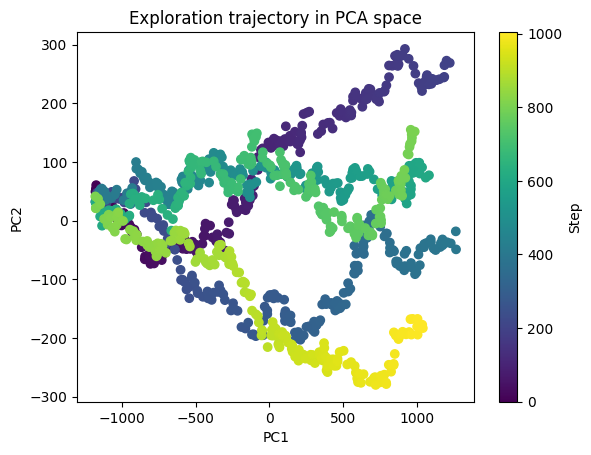

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

path = f"timewarp_pure_sampling_multi/exploration_coords_multi.npy"
coords = np.load(path)  # (201, 22, 3)
X = coords.reshape(coords.shape[0], -1)  # (201, 66)

pca = PCA(n_components=2)
proj = pca.fit_transform(X)

plt.scatter(proj[:, 0], proj[:, 1], c=np.arange(len(proj)), cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Exploration trajectory in PCA space')
plt.colorbar(label='Step')
plt.show()

In [ ]:
%cd /content/drive/MyDrive/Resultats/Timewarp

/content/drive/MyDrive/Resultats/Timewarp


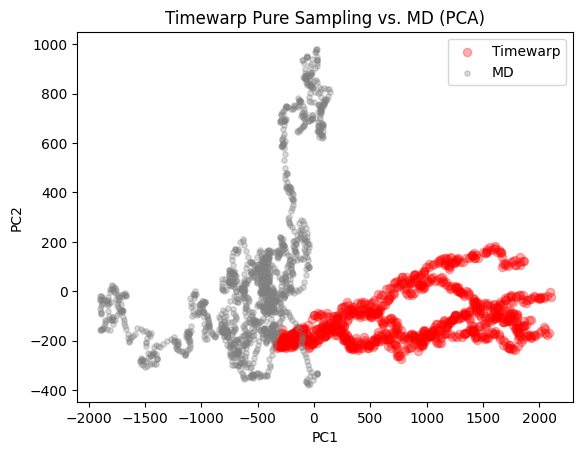

In [ ]:

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#Comparaison entre MD et sampling

# 1. 加载 timewarp 采样
tw_coords = np.load('timewarp_exploration/timewarp_pure_sampling_multi/exploration_coords_multi.npy')  # (N1, 22, 3)
tw_coords_flat = tw_coords.reshape(tw_coords.shape[0], -1)

# 2. 加载 MD 采样（如前4条合并）
all_md_coords = []
for i in range(4):
    arr = np.load(f'data_1/traj_{i}_addition.npy')
    arr = arr.reshape(-1, 22, 3)
    all_md_coords.append(arr)
all_md_coords = np.concatenate(all_md_coords, axis=0)
md_coords_flat = all_md_coords.reshape(all_md_coords.shape[0], -1)

# 3. 合并 PCA
all_coords = np.concatenate([tw_coords_flat, md_coords_flat], axis=0)
pca = PCA(n_components=2)
proj = pca.fit_transform(all_coords)
n_tw = tw_coords_flat.shape[0]

# 4. 绘图
plt.scatter(proj[:n_tw, 0], proj[:n_tw, 1], c='red', alpha=0.3, s=35, label='Timewarp')
plt.scatter(proj[n_tw:, 0], proj[n_tw:, 1], c='grey', alpha=0.3, s=15, label='MD')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.legend()
plt.title('Timewarp Pure Sampling vs. MD (PCA)')
plt.show()

**Analyse-II**

In [ ]:
%cd /content/drive/MyDrive/Resultats/Timewarp

/content/drive/MyDrive/Resultats/Timewarp


In [ ]:
!pip install mdtraj

**Analyse-III**

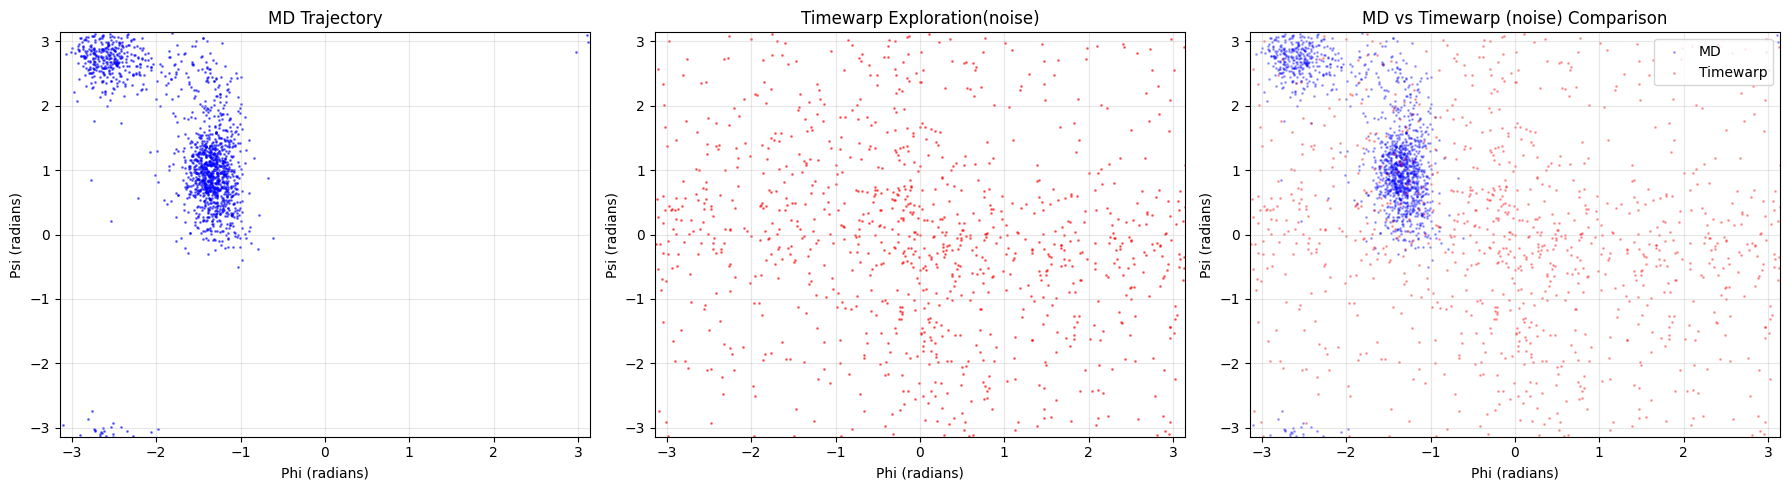

=== Ramachandran Plot Analysis ===
MD trajectory:
  Phi range: -3.102 to 3.117
  Psi range: -3.140 to 3.136
  Total frames: 1504

Timewarp exploration:
  Phi range: -3.127 to 3.139
  Psi range: -3.132 to 3.117
  Total frames: 1005

Coverage comparison:
MD phi std: 0.600, psi std: 1.056
TW phi std: 1.624, psi std: 1.463


In [ ]:
#Analyse III-2
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 加载原始MD生成的全部轨迹
all_coords = []
for i in range(4):
    arr = np.load(f'data_1/traj_{i}_addition.npy')
    # Reshape each loaded array to (N_frames, 22, 3)
    # Assuming the original shape might be something like (1, N_frames, 22, 3) or (N_frames, 22, 3)
    # Using -1 lets numpy infer the number of frames
    arr = arr.reshape(-1, 22, 3)
    all_coords.append(arr)
all_coords = np.concatenate(all_coords, axis=0)  # [N_total, 22, 3]
pdb = md.load_pdb('alanine-dipeptide-solvated.pdb')
traj = md.Trajectory(all_coords, pdb.topology)
phi_md = md.compute_phi(traj)[1]
psi_md = md.compute_psi(traj)[1]


# 加载timewarp exploration生成的所有轨迹
all_coords_tw = []
for idx in [0, 50, 100, 150, 200]:
    # Correcting the file path based on the exploration output directory structure
    file_path = f'timewarp_exploration/timewarp_pure_sampling_{idx}/exploration_coords.npy'
    coords = np.load(file_path)
    # Reshape the loaded coordinates similarly
    coords = coords.reshape(-1, 22, 3)
    all_coords_tw.append(coords)
all_coords_tw = np.concatenate(all_coords_tw, axis=0)  # 一定要合并
traj_tw = md.Trajectory(all_coords_tw, pdb.topology)
phi_tw = md.compute_phi(traj_tw)[1]
psi_tw = md.compute_psi(traj_tw)[1]


# 现在 phi_md, psi_md, phi_tw, psi_tw 都可以后续绘图/分析



# 绘制Ramachandran plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. MD轨迹的Ramachandran plot
axes[0].scatter(phi_md.flatten(), psi_md.flatten(),
               c='blue', alpha=0.5, s=1, label='MD')
axes[0].set_xlabel('Phi (radians)')
axes[0].set_ylabel('Psi (radians)')
axes[0].set_title('MD Trajectory')
axes[0].set_xlim([-np.pi, np.pi])
axes[0].set_ylim([-np.pi, np.pi])
axes[0].grid(True, alpha=0.3)

# 2. Timewarp exploration的Ramachandran plot
axes[1].scatter(phi_tw.flatten(), psi_tw.flatten(),
               c='red', alpha=0.5, s=1, label='Timewarp')
axes[1].set_xlabel('Phi (radians)')
axes[1].set_ylabel('Psi (radians)')
axes[1].set_title('Timewarp Exploration(noise)')
axes[1].set_xlim([-np.pi, np.pi])
axes[1].set_ylim([-np.pi, np.pi])
axes[1].grid(True, alpha=0.3)

# 3. 对比图
axes[2].scatter(phi_md.flatten(), psi_md.flatten(),
               c='blue', alpha=0.3, s=1, label='MD')
axes[2].scatter(phi_tw.flatten(), psi_tw.flatten(),
               c='red', alpha=0.3, s=1, label='Timewarp')
axes[2].set_xlabel('Phi (radians)')
axes[2].set_ylabel('Psi (radians)')
axes[2].set_title('MD vs Timewarp (noise) Comparison')
axes[2].set_xlim([-np.pi, np.pi])
axes[2].set_ylim([-np.pi, np.pi])
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ramachandran_comparison_1.png', dpi=300, bbox_inches='tight')
plt.show()

# 计算统计信息
print("=== Ramachandran Plot Analysis ===")
print(f"MD trajectory:")
print(f"  Phi range: {phi_md.min():.3f} to {phi_md.max():.3f}")
print(f"  Psi range: {psi_md.min():.3f} to {psi_md.max():.3f}")
print(f"  Total frames: {len(phi_md.flatten())}")

print(f"\nTimewarp exploration:")
print(f"  Phi range: {phi_tw.min():.3f} to {phi_tw.max():.3f}")
print(f"  Psi range: {psi_tw.min():.3f} to {psi_tw.max():.3f}")
print(f"  Total frames: {len(phi_tw.flatten())}")

# 检查覆盖的二面角区域
phi_md_flat = phi_md.flatten()
psi_md_flat = psi_md.flatten()
phi_tw_flat = phi_tw.flatten()
psi_tw_flat = psi_tw.flatten()

print(f"\nCoverage comparison:")
print(f"MD phi std: {phi_md_flat.std():.3f}, psi std: {psi_md_flat.std():.3f}")
print(f"TW phi std: {phi_tw_flat.std():.3f}, psi std: {psi_tw_flat.std():.3f}")

In [ ]:
# 识别主要的metastable states (basins)
def find_main_basins(phi, psi, n_bins=20):
    """识别Ramachandran plot中的主要basin"""
    hist, phi_edges, psi_edges = np.histogram2d(
        phi.flatten(), psi.flatten(), bins=n_bins
    )

    # 找到密度最高的区域
    flat_hist = hist.flatten()
    sorted_indices = np.argsort(flat_hist)[::-1]

    # 转换回2D坐标
    top_basins = []
    for i in range(min(5, len(sorted_indices))):  # 前5个basin
        if flat_hist[sorted_indices[i]] > 0:
            idx_2d = np.unravel_index(sorted_indices[i], hist.shape)
            phi_center = (phi_edges[idx_2d[0]] + phi_edges[idx_2d[0]+1]) / 2
            psi_center = (psi_edges[idx_2d[1]] + psi_edges[idx_2d[1]+1]) / 2
            count = flat_hist[sorted_indices[i]]
            top_basins.append((phi_center, psi_center, count))

    return top_basins

md_basins = find_main_basins(phi_md, psi_md)
tw_basins = find_main_basins(phi_tw, psi_tw)

print(f"\n=== Main Basins Analysis ===")
print("MD main basins (phi, psi, count):")
for i, (phi_c, psi_c, count) in enumerate(md_basins):
    print(f"  Basin {i+1}: ({phi_c:.3f}, {psi_c:.3f}) - {count} frames")

print("\nTimewarp main basins (phi, psi, count):")
for i, (phi_c, psi_c, count) in enumerate(tw_basins):
    print(f"  Basin {i+1}: ({phi_c:.3f}, {psi_c:.3f}) - {count} frames")


=== Main Basins Analysis ===
MD main basins (phi, psi, count):
  Basin 1: (-1.392, 0.782) - 190.0 frames
  Basin 2: (-1.392, 1.096) - 179.0 frames
  Basin 3: (-1.392, 1.410) - 96.0 frames
  Basin 4: (-2.635, 2.665) - 90.0 frames
  Basin 5: (-1.392, 0.468) - 78.0 frames

Timewarp main basins (phi, psi, count):
  Basin 1: (-0.151, 0.461) - 14.0 frames
  Basin 2: (-0.151, -0.164) - 12.0 frames
  Basin 3: (2.355, -0.164) - 11.0 frames
  Basin 4: (0.162, -1.414) - 11.0 frames
  Basin 5: (0.162, -0.164) - 11.0 frames


**Analyse-IV**

In [ ]:
%cd /content/drive/MyDrive/Resultats/Timewarp

/content/drive/MyDrive/Resultats/Timewarp


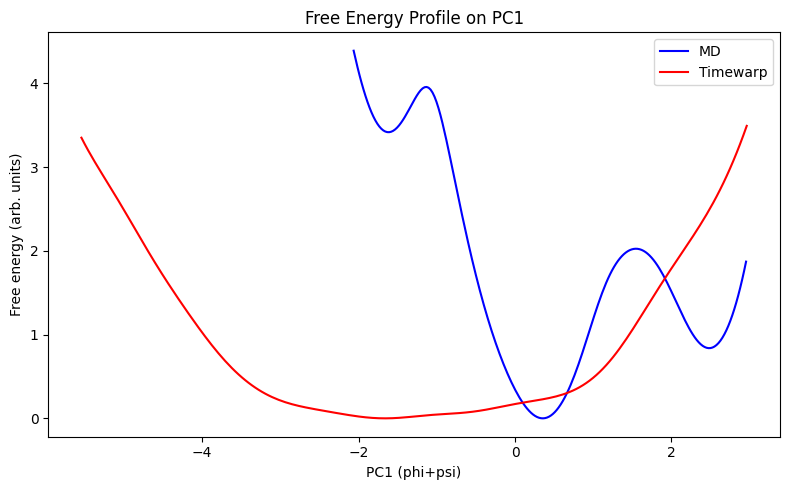

In [ ]:
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde

# 拼合特征
features_md = np.concatenate([phi_md, psi_md], axis=1)
features_tw = np.concatenate([phi_tw, psi_tw], axis=1)

# 合并做PCA（也可以用tICA，如果有pyemma）
features = np.concatenate([features_md, features_tw], axis=0)
pca = PCA(n_components=2)
proj = pca.fit_transform(features)
proj_md = proj[:len(features_md), 0]  # 取PC1
proj_tw = proj[len(features_md):, 0]

# KDE估算自由能
def plot_free_energy_1d(x, label, color):
    kde = gaussian_kde(x)
    xgrid = np.linspace(x.min(), x.max(), 200)
    p = kde(xgrid)
    F = -np.log(p + 1e-10)
    F -= F.min()
    plt.plot(xgrid, F, label=label, color=color)

plt.figure(figsize=(8,5))
plot_free_energy_1d(proj_md, 'MD', 'b')
plot_free_energy_1d(proj_tw, 'Timewarp', 'r')
plt.xlabel('PC1 (phi+psi)')
plt.ylabel('Free energy (arb. units)')
plt.legend()
plt.title('Free Energy Profile on PC1')
plt.tight_layout()
plt.show()